# Capstone 1 Machine Learning
## Predicting Prediabetes and Diabetes with Machine Learning
## NHANES 2007-2016
### Can we accurately predict prediabetes and diabetes with the National Health and Nutrition Examination Survey?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set_context("talk")

In [2]:
# Load data

dtype_dict = {'SEQN': int}
demo_dtype_dict = {"SEQN": int, "SDDSRVYR": int, "RIDSTATR": int, "RIAGENDR": int, "RIDAGEYR": int, 
                   "RIDRETH1": int, "DMDHHSIZ": int, "DMDFMSIZ": int, 
                   "DMDHRGND": int, "DMDHRAGE": int, "SDMVPSU": int, "SDMVSTRA": int}
ques_dtype_dict = {"SEQN": int, "SMDUPCA": object, "SMD100BR": object}

demo = pd.read_csv('data/demo_all.csv', dtype=demo_dtype_dict)
diet = pd.read_csv('data/diet_all.csv', dtype=dtype_dict)
exam = pd.read_csv('data/exam_all.csv', dtype=dtype_dict)
labs = pd.read_csv('data/labs_all.csv', dtype=dtype_dict)
meds = pd.read_csv('data/meds_all.csv', dtype=dtype_dict)
ques = pd.read_csv('data/questionnaire_all.csv', dtype=ques_dtype_dict)

In [3]:
def set_diab(row):
    """
    Return integer indicator for diabetes diagnosis criteria or NaN if no test results found.
        2 = Diabetes
        1 = Prediabetes
        0 = No Diabetes
        NaN = No test results found
        
    Input: row from labs table including three diagnostics tests for diabetes: 
               LBXGH: Fasting Plasma Glucose, 
               LBXGLU: Glycohemoglobin (HbA1c),
               LBXGLT: Oral Glucose Tolerance Test
    """
    if (np.isnan(row['LBXGH']) and np.isnan(row['LBXGLU']) and np.isnan(row['LBXGLT'])):
        return np.NaN
    # Use American Diabetes Association's diagnosis criteria. 
    if (row['LBXGH'] >= 6.5) or (row['LBXGLU'] >= 126) or (row['LBXGLT'] >= 200):
        return 2
    elif (row['LBXGH'] >= 5.7 or row['LBXGLU'] >= 100 or row['LBXGLT'] >= 140):
        return 1
    else:
        return 0


labs = labs.assign(DIAB=labs.apply(set_diab, axis=1))
labs.DIAB.value_counts()

0.0    17476
1.0    10939
2.0     4087
Name: DIAB, dtype: int64

## Processing Plan

I. Models with target = DIAB indicator (0, 1, 2 based on diagnostic labs per ADA guidelines)

1. Remove features with more than 40% null values as measured by number of Glycohemoglobin values. 
2. Split train/test with stratification of diab indicator values. 
2. Fill in missing data with imputed values.
3. Convert categorical data to numeric.  
   Meds are categorical strings. Others? Look in demo. All string data dropped. None to convert. 
3. Convert categorical nominal to dummy variables.    
4. Scale continuous data? Some features may need to be scaled. Many features have outliers/long right tails.  
   Scale for logistic regression. No need to scale for tree models. 


II. Models with target = ICD-10 code (subset of data = 4 yrs)

1. Remove rows without ICD-10 code data (6 years of data)
1. Remove features with more than 40% null values as measured by ICD-10 code. 
2. Split train/test with stratification of ICD-10 codes. 
3. Fill in missing data with imputed values.
3. Convert categorical data to numeric.  
   Meds are categorical strings. Others? Look in demo. All string data dropped. None to convert. 
3. Convert categorical nominal to dummy variables.   
4. Scale continuous data? Some features may need to be scaled. Many features have outliers/long right tails.  
   Scale for logistic regression. No need to scale for tree models. 


## I. Models with target = DIAB indicator
###    Preprocessing

In [4]:
# How many participants are in each dataframe? Data key is SEQN, unique identifier for each participant. 

n_demo = demo.SEQN.nunique()
n_diet = diet.SEQN.nunique()
n_exam = exam.SEQN.nunique()
n_labs = labs.SEQN.nunique()
n_meds = meds.SEQN.nunique()
n_ques = ques.SEQN.nunique()
print(f"Demo count: {n_demo}\nDiet count: {n_diet}\nExam count: {n_exam}\nLabs count: {n_labs}\nMeds count: {n_meds}", 
          f"\nQuestionnaire count: {n_ques}")
n_null_LBXGH = labs.LBXGH.isna().sum()
print(f"\nNull Glycohemoglobin count: {n_null_LBXGH}")

Demo count: 50588
Diet count: 47156
Exam count: 48710
Labs count: 46685
Meds count: 50588 
Questionnaire count: 50588

Null Glycohemoglobin count: 14214


In [5]:
# Duplicate SEQNs in dataframes? Only in Meds. 
print(f"Demo: {demo.SEQN.value_counts().head(1).values}")
print(f"Diet: {diet.SEQN.value_counts().head(1).values}")
print(f"Exam: {exam.SEQN.value_counts().head(1).values}")
print(f"Labs: {labs.SEQN.value_counts().head(1).values}")
print(f"Meds: {meds.SEQN.value_counts().head(1).values}")
print(f"Ques: {ques.SEQN.value_counts().head(1).values}")

Demo: [1]
Diet: [1]
Exam: [1]
Labs: [1]
Meds: [23]
Ques: [1]


In [6]:
# Use only:
#         SEQN: unique identifier, 
#         RXDUSE: Do you use prescription medications?, 
#         RXDCOUNT: How many prescriptions do you take? 
#     from meds dataframe. All others have a many to one relationship with target feature. Need to use OneHotEncoder 
#     if keeping them as features but there are 1115 different medications. That is a lot of very sparse features. 

ml_meds = meds[['SEQN', 'RXDUSE', 'RXDCOUNT']].drop_duplicates()
ml_meds.shape

(50588, 3)

In [7]:
# Determine cutoff for dropping columns with too many null values. 

n_LBXGH = labs[labs.LBXGH.notnull()]['LBXGH'].count()
null_cutoff = int(n_LBXGH * .4)
print(f"Number of Glycohemoglobin labs: {n_LBXGH}\n40% of Glycohemoglobin labs: {null_cutoff}")

Number of Glycohemoglobin labs: 32471
40% of Glycohemoglobin labs: 12988


In [8]:
# Merge all dataframes into one by combining on SEQN, unique participant identification number. 

full_data = labs.merge(demo, on='SEQN', how='left')
full_data = full_data.merge(diet, on='SEQN', how='left')
full_data = full_data.merge(exam, on='SEQN', how='left')
full_data = full_data.merge(ml_meds, on='SEQN', how='left')
full_data = full_data.merge(ques, on='SEQN', how='left')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46685 entries, 0 to 46684
Columns: 875 entries, SEQN to WHQ520
dtypes: float64(861), int32(12), object(2)
memory usage: 309.9+ MB


In [9]:
# Drop any rows with missing LBXGH as we used non-null LBXGH as our measure of full data. Per the NHANES documentation: 
#    Glycohemoglobin measures are available for a full sample of participants aged 12 years and older. 
#    The other Diabetes measures (mostly) do not exist for the observations with null LBXGH. In addition, not all LBXGH 
#    values have corresponding LBXGLU or LBXGLT values as those must be measured in a fasted state and were only drawn in 
#    lab tests drawn in the morning sessions. 
#    Per the NHANES documentation: There are seven exclusion criteria for the LBXGLU or LBXGLT tests, including hemophilia 
#    and chemotherapy safety exclusions, fasting < 9 hours, taking insulin or oral medications for diabetes, refusing 
#    phlebotomy, and not drinking all the Trutol solution (for LGXGLT) within the allotted time.

# How many non-null LBXGLU and LBXGLT values are there for null LBXGH observations? Both LBXGLU and LBXGLT null counts are 
#    above the null value cutoff. 
print(full_data[full_data.LBXGH.isna() == True][['LBXGLU', 'LBXGLT']].count())
print(full_data.shape)
gh_data = full_data.dropna(subset=['LBXGH'], how='any').copy()
print(gh_data.shape)

LBXGLU    31
LBXGLT    21
dtype: int64
(46685, 875)
(32471, 875)


In [10]:
# Change 5555, 777, 7777, 999 and 9999 values in various features. These features are continuous with the addition of these
#    codes to represent "over 21", refused to answer" and "don't know". Removing these code values will allow the
#    features to be modeled as continuous. 
gh_data.replace({'WHD050':{7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'WHD120':{7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'WHD140':{7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'WHQ150':{7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'PAD680':{7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'ALQ120Q':{777:np.nan,999:np.nan}},inplace=True)
gh_data.replace({'DBD895':{5555:21,7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'DBD900':{5555:21,7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'DBD905':{7777:np.nan,9999:np.nan}},inplace=True)
gh_data.replace({'DBD910':{7777:np.nan,9999:np.nan}},inplace=True)

In [11]:
# Create boolean mask of columns to keep by finding those with # of null values below cutoff value.
cols_to_keep = gh_data.isna().sum() < null_cutoff
ml_data = gh_data.iloc[:, cols_to_keep.values].copy()

In [12]:
# How much data is left?
ml_data.shape

(32471, 362)

In [13]:
# Verify no duplicate rows for any SEQNs. 
ml_data.SEQN.nunique()

32471

In [14]:
# Make sure we have a target for each observation. 
ml_data.DIAB.isnull().sum()

0

In [15]:
# Check for string data. No string data left. 
ml_data.dtypes.value_counts()

float64    350
int32       12
dtype: int64

In [16]:
# Which/how many columns have null values?

ml_data.columns[ml_data.isnull().sum().values > 0]

Index(['URXCRS', 'URXUCR', 'URXUMA', 'URXUMS', 'LBDSALSI', 'LBDSBUSI',
       'LBDSCASI', 'LBDSCHSI', 'LBDSCRSI', 'LBDSGBSI',
       ...
       'SMQ020', 'WHD010', 'WHD020', 'WHQ030', 'WHQ040', 'WHD050', 'WHQ070',
       'WHD120', 'WHD140', 'WHQ150'],
      dtype='object', length=317)

In [17]:
# Average the three Systolic and Diastolic Blood Pressures and save average, drop individual measurements. 
ml_data = ml_data.assign(BPXSYA = ml_data[['BPXSY1', 'BPXSY2', 'BPXSY3']].mean(axis=1), 
                         BPXDIA = ml_data[['BPXDI1', 'BPXDI2', 'BPXDI3']].mean(axis=1))
ml_data = ml_data.drop(['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXDI1', 'BPXDI2', 'BPXDI3'], axis=1)

In [18]:
# Categorize features for preprocessing: continuous, categorical ordinal, categorical nominal
cont_cols = ['DR1DBIH', 'DR1DAY', 'DR1TNUMF','DR1TKCAL', 'DR1TPROT', 
                 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 
                 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET', 'DR1TVARA', 'DR1TACAR', 
                 'DR1TBCAR', 'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 
                 'DR1TFA', 'DR1TFF', 'DR1TFDFE', 'DR1TCHL', 'DR1TVB12', 'DR1TB12A', 'DR1TVC', 'DR1TVD', 'DR1TVK', 
                 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 
                 'DR1TSELE', 'DR1TCAFF', 'DR1TTHEO', 'DR1TALCO', 'DR1TMOIS', 'DR1TS040', 'DR1TS060', 'DR1TS080', 
                 'DR1TS100', 'DR1TS120', 'DR1TS140', 'DR1TS160', 'DR1TS180', 'DR1TM161', 'DR1TM181', 'DR1TM201', 
                 'DR1TM221', 'DR1TP182', 'DR1TP183', 'DR1TP184', 'DR1TP204', 'DR1TP205', 'DR1TP225', 'DR1TP226', 
                 'DR1_320Z', 'DR1_330Z', 'DR1BWATZ',  
                 'BPXPLS', 'BPXML1', 'BPXSYA', 'BPXDIA', 'BMXWT', 
                 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'URXUMA', 'URXUCR',  
                 'LBXSAL', 'LBXSAPSI', 'LBXSASSI', 'LBXSATSI', 'LBXSBU', 'LBXSC3SI', 'LBXSCA', 
                 'LBXSCLSI', 'LBXSCR', 'LBXSGB', 'LBXSGTSI', 'LBXSIR', 'LBXSKSI', 'LBXSLDSI', 'LBXSNASI', 
                 'LBXSOSSI', 'LBXSPH', 'LBXSTB', 'LBXSTP', 'LBXSTR', 'LBXSUA', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 
                 'LBXNEPCT', 'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBDBANO', 'LBXRBCSI', 
                 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'PHAFSTHR', 'PHAFSTMN', 
                 'LBDHDD', 'LBXIHG', 'LBXTC', 'LBXBCD', 'LBXBPB', 'LBXTHG', 'RXDCOUNT', 'RIDAGEYR', 'DMDHHSIZ', 'DMDFMSIZ',
                 'DMDHRAGE', 'INDFMPIR', 'INDFMMPI', 'WHD050', 'WHD120', 'WHD140', 'WHQ150', 'PAD680', 'ALQ120Q', 
                 'DBD895', 'DBD900', 'DBD905', 'DBD910']
cat_ord_cols = []
cat_nom_cols = ['SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDRETH1', 'RIDEXMON', 
                    'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'SIALANG', 'SIAPROXY', 
                    'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 
                    'DMDHRGND', 'DMDHREDU', 'DMDHRMAR', 'INDHHIN2', 
                    'INDFMIN2', 'DR1DRSTZ', 'DRABF', 'DR1LANG', 'DRDINT', 'DBQ095Z', 
                    'DBD100', 'DRQSPREP', 'DRQSDIET', 'DR1_300', 'DR1TWS', 'DRD340', 
                    'DRD360', 'DRD370A', 'DRD370B', 'DRD370C', 'DRD370D', 'DRD370E', 'DRD370F', 
                    'DRD370G', 'DRD370H', 'DRD370I', 'DRD370J', 'DRD370K', 'DRD370L', 'DRD370M', 'DRD370N', 'DRD370O', 
                    'DRD370P', 'DRD370Q', 'DRD370R', 'DRD370S', 'DRD370T', 'DRD370U', 'DRD370V', 'BPAARM', 
                    'BPACSZ', 'BPXPULS', 'BPXPTY', 'BPAEN1', 'BPAEN2', 'BPAEN3', 'BMDSTATS', 'PHQ020', 'PHQ030', 
                    'PHQ040', 'PHQ050', 'PHQ060', 'LBXHA', 'LBXHBS', 'LBXHBC', 'LBDHBG', 'LBDHD', 'LBDIHGLC',  
                    'LBDTHGLC', 'ALQ101', 'BPQ020', 'BPQ060', 'BPQ070', 'BPQ080', 'HSAQUEX', 'HSD010', 
                    'HSQ500', 'HSQ510', 'HSQ520', 'HSQ571', 'HSQ590', 'DIQ010', 'DIQ160', 'DIQ170', 'DIQ180', 
                    'DIQ050', 'DBQ700', 'DBQ197', 'DBQ229', 'DBQ235A', 'DBQ235B', 'DBQ235C', 
                    'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070',
                    'DPQ080', 'DPQ090', 'DUQ240', 'DUQ370', 'HIQ011', 'HIQ270', 'HIQ210', 'HOD050', 
                    'HOQ065', 'HUQ010', 'HUQ020', 'HUQ030', 'HUQ071', 'HUQ090', 'IMQ011', 'IMQ020', 'INQ020', 'INQ012',
                    'INQ030', 'INQ060', 'INQ080', 'INQ090', 'INQ132', 'INQ140', 'INQ150', 'IND235', 
                    'INDFMMPC', 'MCQ010', 'MCQ053', 'MCQ080', 'MCQ092', 'MCQ160A', 'MCQ160N', 'MCQ160B', 'MCQ160C', 
                    'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160G', 'MCQ160M', 'MCQ160K', 'MCQ160L', 'MCQ220', 'MCQ300A', 
                    'MCQ300B', 'MCQ300C', 'OCD150', 'OCD390G', 'PFQ049', 'PFQ051', 'PFQ054', 'PFQ057', 'PFQ059', 
                    'PFQ090', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665', 'SLQ050', 'SMQ020', 'SMAQUEX2', 
                    'WHQ030', 'WHQ040', 'WHQ070', 
                    'SMAQUEX', 'RXDUSE', 'PHDSESN']


In [19]:
# Check that columns are in data. Some columns were dropped in data wrangling step. 
[print(f"No {col} in ml_data.") for col in cont_cols if col not in ml_data.columns]
print("\n")
[print(f"No {col} in ml_data.") for col in cat_ord_cols if col not in ml_data.columns]
print("\n")
[print(f"No {col} in ml_data.") for col in cat_nom_cols if col not in ml_data.columns]     

[]

In [20]:
# Get rid of duplicate columns (same data converted to different units) as they will be perfectly correlated. 
#    Also drop LBXGH as it was used to create target. Also drop LBXSGL as it is highly correlated with a feature used
#    to create target. 
#    Drop WHD010 as it is highly correlated with BMXHT, WHD020 as it is highly correlated with BMXWT. 
#    Drop survey weights and survey analysis parameters as they are moot to diabetes/prediabetes predictions. They are 
#    only valid for applying survey results to population as a whole, not predicting for an individual. 
#    Drop Interviewer ID code as it is moot to diabetes/prediabetes prediction. 
dup_cols = ['URXUMS', 'URXCRS',
            'LBDSALSI', 'LBDSBUSI', 'LBDSCASI', 'LBDSCHSI', 'LBDSCRSI', 'LBDSGBSI', 'LBDSGLSI', 'LBDSIRSI', 
            'LBDSPHSI', 'LBDSTBSI', 'LBDSTPSI', 'LBDSTRSI', 'LBDSUASI', 'LBDHDDSI', 'LBDIHGSI', 'LBDTCSI', 'LBDBCDSI', 
            'LBDBPBSI', 'LBDTHGSI', 'LBXSCH', 'LBXGH', 'LBXSGL', 'WHD010', 'WHD020',
            'WTINT2YR', 'WTMEC2YR', 'WTDRD1', 'WTDR2D', 'SDMVPSU', 'SDMVSTRA', 'DR1EXMER']
ml_data = ml_data.drop(dup_cols, axis=1)

In [21]:
# Make sure we have accounted for all columns and haven't overlooked any. 
missing_cols = list(set(ml_data.columns) - set(cont_cols) - set(cat_ord_cols) - set(cat_nom_cols) - set(dup_cols) \
                    - set(('SEQN', 'DIAB')))
print(missing_cols)

[]


In [22]:
# Divide data into train and test before preprocessing to avoid leakage. Stratify on DIAB target indicator. Do not 
#    include SEQN in features as it is just a unique participant identifier. 
from sklearn.model_selection import train_test_split

X = ml_data.drop(['DIAB', 'SEQN'], axis=1)
y = ml_data.DIAB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# How big are our train and test sets?
print(f"Train features: {X_train.shape}\nTrain targets:  {y_train.shape}\nTest features:  {X_test.shape}",
      f"\nTest targets:   {y_test.shape}")

Train features: (22729, 323)
Train targets:  (22729,)
Test features:  (9742, 323) 
Test targets:   (9742,)


In [23]:
def class_proportion(target_col):
    """
    Check proportion of values of Series. 
    
    Return: 
            dict of {value: proportion} for each value in input Series
            
    Input:
            pandas Series
    """
    grp = target_col.value_counts()
    return {idx: round(val/len(target_col), 3) for idx, val in grp.items()}
print(f"Original data target class proportion: {class_proportion(ml_data['DIAB'])}")
print(f"Training data target class proportion: {class_proportion(y_train)}")
print(f"Test data target class proportion:     {class_proportion(y_test)}")

Original data target class proportion: {0.0: 0.538, 1.0: 0.337, 2.0: 0.126}
Training data target class proportion: {0.0: 0.538, 1.0: 0.337, 2.0: 0.126}
Test data target class proportion:     {0.0: 0.538, 1.0: 0.337, 2.0: 0.126}


In [24]:
# Fill null values with imputed values. Use IterativeImputer to get better estimates than mean or median. Use default
# estimator of BayesianRidge() with 5 other feature columns to estimate missing values. 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

#Limit nearest features so compute time is reasonable. 
imp = IterativeImputer(n_nearest_features=5, random_state=42)

X_train_filled = pd.DataFrame(imp.fit_transform(X_train))
X_train_filled.columns = X_train.columns


C:\Users\tracy\Anaconda3\envs\capstone1\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [25]:
# Fill nulls in test data with fit from training data. 
X_test_filled = pd.DataFrame(imp.transform(X_test))
X_test_filled.columns = X_test.columns

In [26]:
# Scale continuous features for better model convergence. 
# Note: output of StandardScaler is np.array. Convert back to DataFrame to do pd.concat with rest of features. 
# StandardScaler output is only columns that were transformed, not rest of dataframe. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train_cont = pd.DataFrame(scaler.fit_transform(X_train_filled[cont_cols]))
scaled_X_test_cont = pd.DataFrame(scaler.transform(X_test_filled[cont_cols]))
# Give DataFrames column names and set indexes to original indexes. Needs to match index of other features for 
#    correct pd.concat processing. 
scaled_X_train_cont.columns = cont_cols
scaled_X_train_cont.index = X_train.index
scaled_X_test_cont.columns = cont_cols
scaled_X_test_cont.index = X_test.index
print(f"Size of train set: {scaled_X_train_cont.shape}, Size of test set: {scaled_X_test_cont.shape}")

Size of train set: (22729, 149), Size of test set: (9742, 149)


In [27]:
# Convert categorical nominal features to dummy variables for modeling. Round nominal features from filled dataframe 
#    before converting as imputer filled with continuous values between min and max of original data. Rounding 
#    brings imputed continuous values back to integer categories.   
from pandas.api.types import CategoricalDtype

X_train_dummy = round(X_train_filled.loc[:,cat_nom_cols], 0).apply(lambda x: x.astype('category'))
# Get categories from train set to define categories in test set. 
X_train_cats = {col: CategoricalDtype(categories=X_train_dummy[col].cat.categories.to_list()) \
                for col in X_train_dummy.columns}
# Now convert category column to dummy variables for modeling. Drop_first as some add up to 1 - don't want to 
#    cause problem with model. 
X_train_dummy = pd.get_dummies(X_train_dummy, drop_first=True)
X_train_dummy.index = X_train.index

# Use train categories on test data. Will drop any values not in category list. 
X_test_dummy = round(X_test_filled.loc[:,cat_nom_cols], 0)
 
X_test_dummy = X_test_dummy.astype(X_train_cats)
X_test_dummy = pd.get_dummies(X_test_dummy, columns=cat_nom_cols, drop_first=True)
X_test_dummy.index = X_test.index

# Get columns from training that are missing in test as fewer values in test for get_dummies.
missing_cols = set(X_train_dummy.columns) - set(X_test_dummy.columns)
# Add each missing column to test set with value equal to 0.
for c in missing_cols:
    X_test_dummy[c] = 0
# Ensure the order of columns in the test set is the same as in train set.
X_test_dummy = X_test_dummy[X_train_dummy.columns]

print(f"Size of categorical nominal features: train: {X_train_dummy.shape}, test: {X_test_dummy.shape}")

Size of categorical nominal features: train: (22729, 566), test: (9742, 566)


In [28]:
# Pull out categorical ordinal data to concatenate into features DataFrame. 
X_train_cat_ord = X_train_filled.loc[:, cat_ord_cols]
X_test_cat_ord = X_test_filled.loc[:, cat_ord_cols]
X_train_cat_ord.index = X_train.index
X_test_cat_ord.index = X_test.index
print(f"Size of categorical ordinal features: train: {X_train_cat_ord.shape}, test: {X_test_cat_ord.shape}")

Size of categorical ordinal features: train: (22729, 0), test: (9742, 0)


In [29]:
X_train_processed_df = pd.concat([scaled_X_train_cont, X_train_dummy, X_train_cat_ord], axis=1)
X_test_processed_df = pd.concat([scaled_X_test_cont, X_test_dummy, X_test_cat_ord], axis=1)
print(f"Size of feature set: train: {X_train_processed_df.shape}, test: {X_test_processed_df.shape}")

Size of feature set: train: (22729, 715), test: (9742, 715)


In [30]:
# Convert dataframes to numpy arrays for modeling. 
X_train_processed = np.array(X_train_processed_df)
X_test_processed = np.array(X_test_processed_df)
y_train = np.array(y_train).squeeze()
y_test = np.array(y_test).squeeze()
print(X_train_processed.shape, y_train.shape)

(22729, 715) (22729,)


### a. Logistic Regression Model

In [31]:
# Use default parameters. Set max_iter=2000 so algorithm will converge with this data. 
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=0, class_weight='balanced', 
                           max_iter=2000, multi_class='auto').fit(X_train_processed, y_train)

In [32]:
y_pred = lr_clf.predict(X_test_processed)

In [33]:
# How close is predicted distribution to original distribution?
def predict_proportion(y_pred):
    """
    Calculate distribution of classes in classifier prediction array. 
    
    Returns:
                np.array of proportions in shape (n_classes), rounded to 3 decimal places
                
    Input:
                y_pred (np.array): results of classifier.predict()
    """
    
    unique_pred, count_pred = np.unique(y_pred, return_counts=True)
    tot_pred = y_pred.shape[0]
    pct_pred = [np.true_divide(count_pred[i], tot_pred) for i in range(unique_pred.shape[0])]
    return(np.round(pct_pred, 3))

predict_proportion(y_pred)

array([0.496, 0.361, 0.144])

In [34]:
pred_prob = lr_clf.predict_proba(X_test_processed)

In [35]:
# Overall accuracy from test dataset. 
accuracy = lr_clf.score(X_test_processed, y_test)
print(f"Overall model accuracy: {accuracy}")

Overall model accuracy: 0.7154588380209402


In [36]:
# Check accuracy with 5-fold cross validation. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(lr_clf, X_train_processed, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

C:\Users\tracy\Anaconda3\envs\capstone1\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 71.754% (0.274%)


In [37]:
# Get precision, recall, f1 score. Prediabetes class = 1. 
#    Poor model performance. Not much better than chance at predicting prediabetes. 
from sklearn.metrics import precision_recall_fscore_support
precision = np.empty(3)
recall = np.empty(3)
fscore = np.empty(3)
target_count = np.empty(3)
precision, recall, fscore, target_count = precision_recall_fscore_support(y_test, y_pred, average=None)
# Look at values for prediabetes
print(f" Prediabetes Precision: {round(precision[1],3)}, Recall: {round(recall[1], 3)}, F-score: {round(fscore[1], 3)}")

 Prediabetes Precision: 0.585, Recall: 0.627, F-score: 0.605


In [38]:
# Confusion matrix: actual is rows, predicted is columns. 0,0 top left; 2,2 bottom right. 
#    Lots of actual prediabetes predicted no diabetes; actual no diabetes predicted prediabetes. 
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)

In [39]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.82      0.75      0.79      5238
 Prediabetes       0.58      0.63      0.60      3280
    Diabetes       0.69      0.79      0.73      1224

    accuracy                           0.72      9742
   macro avg       0.70      0.72      0.71      9742
weighted avg       0.72      0.72      0.72      9742



In [40]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.81, Prediabetes: 0.77, Diabetes: 0.95


In [41]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_multiclass_roc_df(clf, X_test, y_test, n_classes, figsize=(12, 6)):
    """
    Plot roc and calculate roc_auc for multiclass model supporting .decision_function().
    
    Input: 
        clf: Trained OneVsRestClassifier
        X_test: Test feature dataset to be used to get prediction probabilities for classifier
        y_test: True class values for test features in shape [n_samples,]
        n_classes: number of classes
        figsize: Figure size of plot, optional
    """
    y_score = clf.decision_function(X_test)

    # labels
    labels = ['No Diabetes', 'Prediabetes', 'Diabetes']

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    print(y_score.shape, y_test_dummies.shape)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curves from Multiclass Predictions')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    

(9742, 3) (9742, 3)


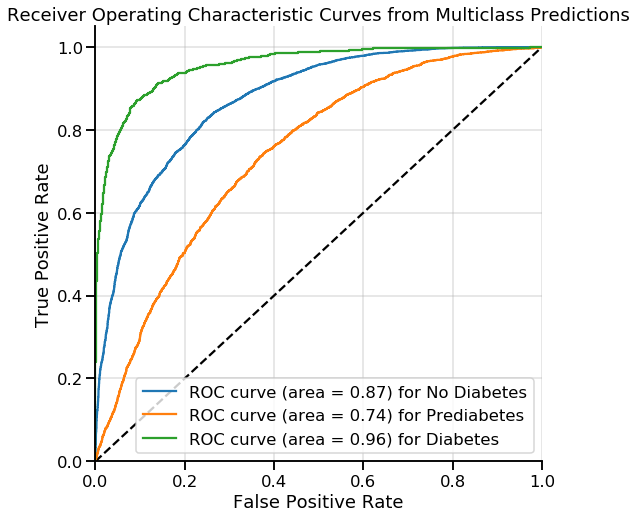

In [42]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(random_state=0, class_weight='balanced', max_iter=2000, multi_class='auto')
roc_clf = OneVsRestClassifier(estimator).fit(X_train_processed, y_train)
plot_multiclass_roc_df(roc_clf, X_test_processed, y_test, n_classes=3, figsize=(8, 8))

#### This model is much better at predicting diabetes than prediabetes. It is not much better than chance at predicting prediabetes. 

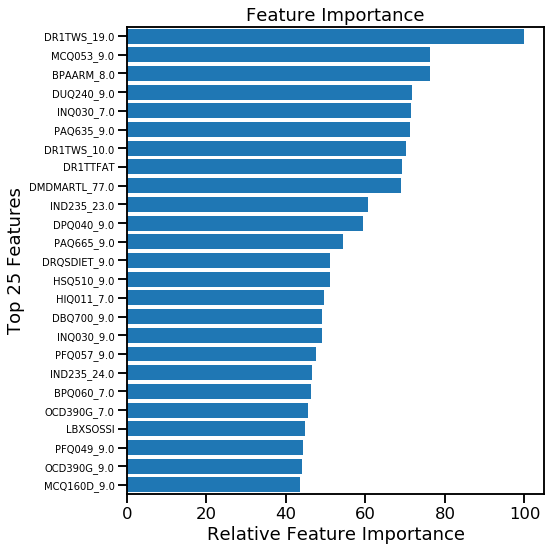

In [43]:
# Look at top 25 features
def plot_top_features_coef(clf, X_train, n_features, n_coef):
    """
    Plot top features from a classifier that has a coef_ attribute. 
    
    Input:
            clf:        classifier having a coef_ attribute
            X_train:    training dataset, used to get feature names
            n_features: number of features to plot
            n_coef:     index of coef_ to plot
    """
    feature_importance = abs(clf.coef_[n_coef])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)

    top_features = feature_importance[np.argsort(feature_importance)[-n_features:]]
    top_labels = X_train.columns[np.argsort(feature_importance)[-n_features:]]
    pos = np.arange(top_features.shape[0]) + .5

    featfig = plt.figure(figsize = (8, 8))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, top_features)
    featax.set_yticks(pos)
    featax.set_yticklabels(top_labels, fontsize=10)
    featax.set_ylim(0, n_features)
    featax.set_xlabel('Relative Feature Importance')
    ylab = 'Top ' + str(n_features) + ' Features'
    featax.set_ylabel(ylab)
    featax.set_title('Feature Importance')

    plt.tight_layout()   
    plt.show()

plot_top_features_coef(lr_clf, X_train_processed_df, 25, 1)

####  Top features:
DR1TWS_19.0 = Tap water source = Other  
MCQ053_9.0 = Been on treatment for anemia in last 3 months = Don't know  
BPAARM_8.0 = Arm selected for Blood Pressure Measurement = Could not obtain  
DUQ240_9.0 = Ever used cocaine / methamphetamine / heroin = Don't know  
INQ030_7.0 = Income from Social Security or Railroad Retirement = Refused to answer   
PAQ635_9.0 = Walk or use a bicycle 10 minutes continuously to go places = Don't know  
DR1TWS_10.0 = Tap water source = Other   
DR1TTFAT = Dietary intake (one day) total fat (g)  
DMDMARTL_77.0 = Marital Status = Refused to answer  
IND235_23.0 = Monthly family income = Other    

###  b. Decision Tree

In [44]:
# No need to use scaled data for decision tree. 
# Pull out continuous data to concatenate with dummies. 
X_train_cont = X_train_filled.loc[:, cont_cols]
X_test_cont = X_test_filled.loc[:, cont_cols]
X_train_cont.index = X_train.index
X_test_cont.index = X_test.index
# Need to use dummy variables for sklearn trees. 
X_train_tree_df = pd.concat([X_train_cont, X_train_dummy, X_train_cat_ord], axis=1)
X_test_tree_df = pd.concat([X_test_cont, X_test_dummy, X_test_cat_ord], axis=1)
print(f"Size of feature set: train: {X_train_tree_df.shape}, test: {X_test_tree_df.shape}")

Size of feature set: train: (22729, 715), test: (9742, 715)


In [45]:
# Use default parameters. 
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
dt_clf.fit(X_train_tree_df, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [46]:
y_pred = dt_clf.predict(X_test_tree_df)

In [47]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.539, 0.34 , 0.121])

In [48]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.597 



In [49]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(dt_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 60.113% (0.381%)


In [50]:
precision, recall, fscore, target_count = precision_recall_fscore_support(y_test, y_pred, average=None)
print(f"Prediabetes Precision: {np.round(precision[1],3)}, Recall: {np.round(recall[1], 3)}, F-score: {np.round(fscore[1], 3)}")

Prediabetes Precision: 0.454, Recall: 0.459, F-score: 0.456


In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3661, 1407,  170],
       [1412, 1504,  364],
       [ 178,  399,  647]], dtype=int64)

In [52]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.70      0.70      0.70      5238
 Prediabetes       0.45      0.46      0.46      3280
    Diabetes       0.55      0.53      0.54      1224

    accuracy                           0.60      9742
   macro avg       0.57      0.56      0.56      9742
weighted avg       0.60      0.60      0.60      9742



In [53]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.65, Prediabetes: 0.72, Diabetes: 0.94


**OneVsRestClassifier yields NaN values in predict_proba with this data and DecisionTreeClassifier with default parameters. This causes errors in roc_curve function. As a result, doing one vs rest processing manually as it works correctly with same data and classifier.** 

In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_3_classifier_roc_pr(clf_0, clf_1, clf_2, X_test, y_test, figsize=(12, 6)):
    """
    Plot results of manual one vs rest modeling for 3 classes on same axes. 
    
    Input: 
        clf_0: Trained one vs rest classifier for class 0
        clf_1: Trained one vs rest classifier for class 1
        clf_2: Trained one vs rest classifier for class 2
        X_test: Test feature dataset to be used to get prediction probabilities for classifiers
        y_test: True class values for Test features in shape [n_samples,]
        figsize: Figure size of plot, optional
    """
    n_classes=3
    
    # Convert y_test to dummies for plotting. 
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    
    # Load positive class probabilities into y_score for plotting. 
    y_score=np.empty_like(y_test_dummies)
    y_score[:,0] = clf_0.predict_proba(X_test)[:,1]
    y_score[:,1] = clf_1.predict_proba(X_test)[:,1]
    y_score[:,2] = clf_2.predict_proba(X_test)[:,1]
    
    # Class labels
    labels = ['No Diabetes', 'Prediabetes', 'Diabetes']

    # Initialize structures for calculation results.
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot roc for each class.
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curves')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
   

In [55]:
# First do no diabetes vs rest. 
test_no_diab_mask = y_test == 0.0
train_no_diab_mask = y_train == 0.0
y_test_nodiab = np.zeros(len(y_test))
y_test_nodiab[test_no_diab_mask] = 1.
y_train_nodiab = np.zeros(len(y_train))
y_train_nodiab[train_no_diab_mask] = 1.
roc_0_clf = DecisionTreeClassifier(random_state=0, class_weight='balanced').fit(X_train_tree_df, y_train_nodiab)
#plot_roc_pr(roc_0_clf, X_test_tree_df, y_test_nodiab, figsize=(8, 8))

In [56]:
# Next do prediabetes vs rest. 
test_prediab_mask = y_test == 1.0
train_prediab_mask = y_train == 1.0
y_test_prediab = np.zeros(len(y_test))
y_test_prediab[test_prediab_mask] = 1.
y_train_prediab = np.zeros(len(y_train))
y_train_prediab[train_prediab_mask] = 1.
roc_1_clf = DecisionTreeClassifier(random_state=0, class_weight='balanced').fit(X_train_tree_df, y_train_prediab)
#plot_roc_pr(roc_1_clf, X_test_tree_df, y_test_prediab, figsize=(8, 8))

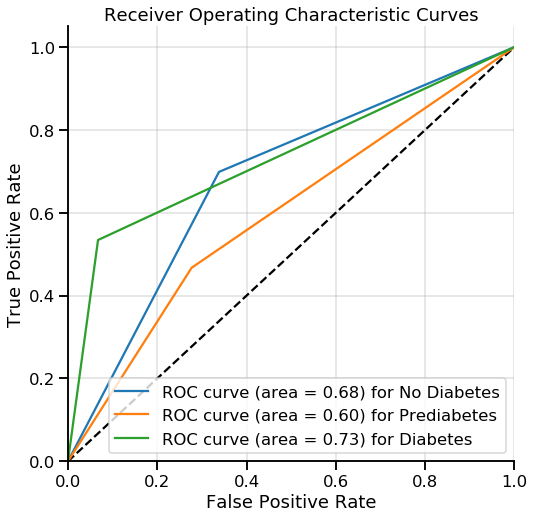

In [57]:
# Lastly do diabetes vs rest and plot. 
test_diab_mask = y_test == 2.0
train_diab_mask = y_train == 2.0
y_test_diab = np.zeros(len(y_test))
y_test_diab[test_diab_mask] = 1.
y_train_diab = np.zeros(len(y_train))
y_train_diab[train_diab_mask] = 1.
roc_2_clf = DecisionTreeClassifier(random_state=0, class_weight='balanced').fit(X_train_tree_df, y_train_diab)
#plot_roc_pr(roc_2_clf, X_test_tree_df, y_test_diab, figsize=(8, 8))
plot_3_classifier_roc_pr(roc_0_clf, roc_1_clf, roc_2_clf, X_test_tree_df, y_test, figsize=(8, 8))

In [58]:
# roc_curve call in plot_multiclass_roc_pr function fails due to NaN values in .predict_proba. Works when doing OVR 
#    processing manually. Bug in OneVsRestClassifier?

#from sklearn.multiclass import OneVsRestClassifier
#estimator = DecisionTreeClassifier(random_state=0, class_weight='balanced')
#roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
#plot_multiclass_roc_pr(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

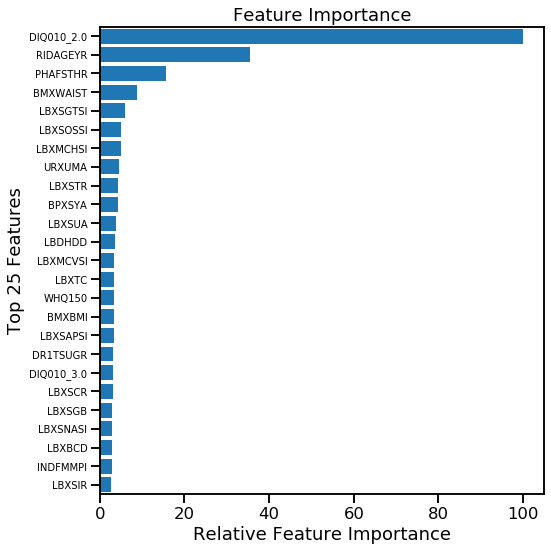

In [59]:
# Look at top 25 features
def plot_top_features_imp(clf, X_train, n_features):
    """
    Plot top features from a classifier that has a feature_importances_ attribute. 
    
    Input:
            clf:        classifier having a feature_importances_ attribute
            X_train:    training dataset, used to get feature names
            n_features: number of features to plot
    """
    
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)

    top_features = feature_importance[np.argsort(feature_importance)[-n_features:]]
    top_labels = X_train.columns[np.argsort(feature_importance)[-n_features:]]
    pos = np.arange(top_features.shape[0]) + .5

    featfig = plt.figure(figsize = (8, 8))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, top_features)
    featax.set_yticks(pos)
    featax.set_yticklabels(top_labels, fontsize=10)
    featax.set_ylim(0, n_features)
    featax.set_xlabel('Relative Feature Importance')
    ylab = 'Top ' + str(n_features) + ' Features'
    featax.set_ylabel(ylab)
    featax.set_title('Feature Importance')

    plt.tight_layout()   
    plt.show()

plot_top_features_imp(dt_clf, X_train_tree_df, 25)

#### Top features:   
DIQ010_2.0 = Doctor ever said you have diabetes = NO    
RIDAGEYR = Age (yr)  
PHAFSTHR = Fasting time before blood draw for labs (hr)  
BMXWAIST = Waist circumference (cm)  
LGXSGTSI = Gamma glutamyl transferase (U/L)  
LBXSOSSI = Osmolality (mmol/Kg)  
LBXMCHSI = Mean cell hemoglobin (pg)  
URXUMA = Albumin, urine (ug/mL)  
LBXSTR = Triglycerides (mg/dL)    
BPXSYA = Systolic Blood pressure (avg of 3 rdgs) mm Hg  

#### Decision Tree is worse than Logistic Regression: barely better than chance by ROC but precision and recall both below .5. On to the next model. 

### c. Random Forest

In [60]:
# Use default parameters. 
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_clf.fit(X_train_tree_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [61]:
y_pred = rf_clf.predict(X_test_tree_df)

In [62]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.642, 0.287, 0.071])

In [63]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.674 



In [64]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(rf_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 67.258% (0.540%)


In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4470,  750,   18],
       [1639, 1530,  111],
       [ 143,  515,  566]], dtype=int64)

In [66]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.71      0.85      0.78      5238
 Prediabetes       0.55      0.47      0.50      3280
    Diabetes       0.81      0.46      0.59      1224

    accuracy                           0.67      9742
   macro avg       0.69      0.59      0.62      9742
weighted avg       0.67      0.67      0.66      9742



In [67]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.6, Prediabetes: 0.8, Diabetes: 0.98


In [68]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_multiclass_roc_pr(clf, X_test, y_test, n_classes, figsize=(12, 6)):
    """
    Plot roc and calculate roc_auc for multiclass model supporting .predict_proba().
    
    Input: 
        clf: Trained OneVsRestClassifier
        X_test: Test feature dataset to be used to get prediction probabilities for classifier
        y_test: True class values for test features in shape [n_samples,]
        n_classes: number of classes
        figsize: Figure size of plot, optional
    """
    y_score = clf.predict_proba(X_test)

    # Define class labels for plot legend.
    labels = ['No Diabetes', 'Prediabetes', 'Diabetes']

    # Initialize structures for calculations.
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Split true values into three dummy vectors for plotting.
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    print(y_score.shape, y_test_dummies.shape)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot roc for each class.
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curves from Multiclass Predictions')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], labels[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    

(9742, 3) (9742, 3)


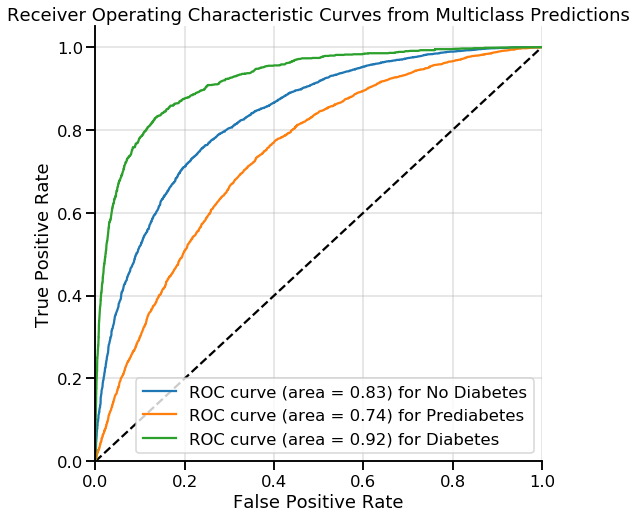

In [69]:
from sklearn.multiclass import OneVsRestClassifier
estimator = RandomForestClassifier(random_state=0, class_weight='balanced')
roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
plot_multiclass_roc_pr(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

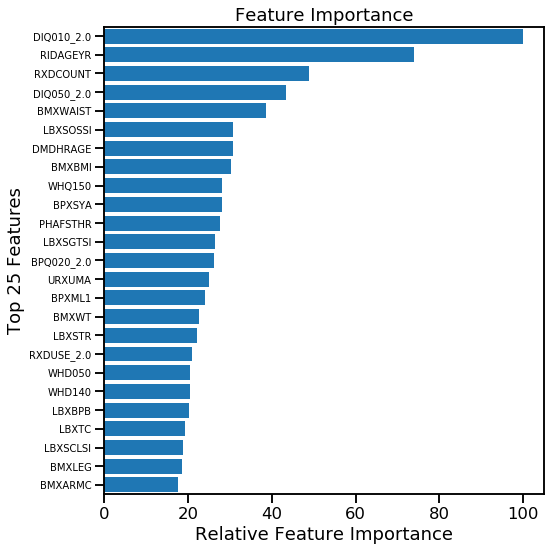

In [70]:
# What features are important to the random forest model?
plot_top_features_imp(rf_clf, X_train_tree_df, 25)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
RIDAGEYR = Age (yr)  
RXDCOUNT = Number of prescription medications currently taking  
DIQ050_2.0 = Taking insulin now = NO  
BMXWAIST = Waist circumference (cm)  
LBXSOSSI = Osmolality (mmol/Kg)  
DMDHRAGE = Age in years of the person who owns or rents the residence (reference person)  
BMXBMI = Body mass index (kg/m^2)  
WHQ150 = Age when heaviest weight  
BPXSYA = Systolic blood pressure (avg of 3 rdgs) (mm Hg)  

#### Now tune the Random Forest model. 

In [71]:
# Use RandomizedSearchCV so we can sample lots of combinations without taking forever. 
from sklearn.model_selection import RandomizedSearchCV

gridsearch_forest = RandomForestClassifier(random_state=0, class_weight='balanced')

params = {
    "max_features": ['sqrt', .2, .3, .4, .5],
    "n_estimators": [100, 200, 300, 400, 500, 600],
    "min_samples_leaf" : [1, 5, 10, 20, 50, 100]
}


rf_clf = RandomizedSearchCV(gridsearch_forest, param_distributions=params, cv=5, n_iter=15, n_jobs=-1, random_state=0)
rf_clf.fit(X_train_tree_df,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [72]:
rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [73]:
best_params = rf_clf.best_params_
best_params

{'n_estimators': 400, 'min_samples_leaf': 5, 'max_features': 0.5}

In [74]:
type(rf_clf)

sklearn.model_selection._search.RandomizedSearchCV

In [75]:
# Fit single classifier with new parameters so we can get feature importance. 
rf_clf = RandomForestClassifier(random_state=0, class_weight='balanced', **best_params)
rf_clf.fit(X_train_tree_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [76]:
y_pred = rf_clf.predict(X_test_tree_df)

In [77]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.538, 0.35 , 0.112])

In [78]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.702 



In [79]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(rf_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 70.681% (0.584%)


In [80]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4113, 1062,   63],
       [1069, 1957,  254],
       [  62,  391,  771]], dtype=int64)

In [81]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.78      0.79      0.78      5238
 Prediabetes       0.57      0.60      0.59      3280
    Diabetes       0.71      0.63      0.67      1224

    accuracy                           0.70      9742
   macro avg       0.69      0.67      0.68      9742
weighted avg       0.70      0.70      0.70      9742



In [82]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.75, Prediabetes: 0.78, Diabetes: 0.96


(9742, 3) (9742, 3)


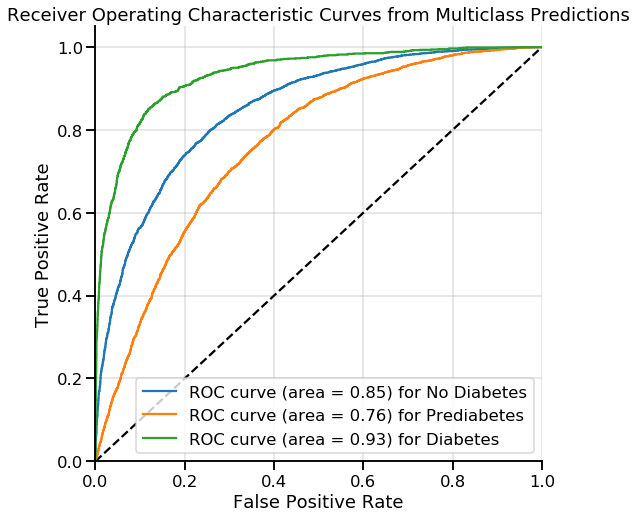

In [83]:
from sklearn.multiclass import OneVsRestClassifier
estimator = RandomForestClassifier(random_state=0, class_weight='balanced', **best_params)
roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
plot_multiclass_roc_pr(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

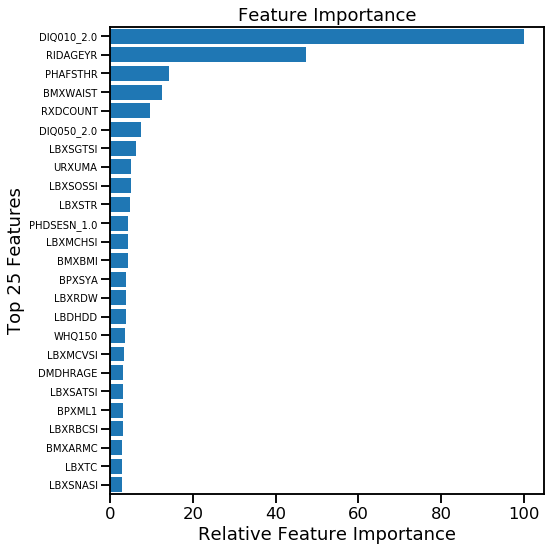

In [84]:
# What features are important to the tuned random forest model?
plot_top_features_imp(rf_clf, X_train_tree_df, 25)

#### Top feaures:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
RIDAGEYR = Age (yr)  
PHAFSTHR = Total fasting time before blood draw for labs (hr)  
BMXWAIST = Waist circumference (cm)  
RXDCOUNT = Number of prescription medications currently taking  
DIQ050_2.0 = Taking insulin now = NO  
LBXSGTSI = Gamma glutamyl transferase (U/L)  
URXUMA = Albumin, urine (ug/mL)  
LBXSOSSI = Osmolality (mmol/Kg)  
LBXSTR = Triglycerides (mg/dL)  

#### Random Forest is better than Decision Tree and tuned version has highest ROC AUC so far. Still not great at predicting prediabetes. On to the next model. 

### d. Adaboost

In [85]:
# Use default parameters. 
from sklearn.ensemble import AdaBoostClassifier
a_clf = AdaBoostClassifier(random_state=0)
a_clf.fit(X_train_tree_df, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=0)

In [86]:
y_pred = a_clf.predict(X_test_tree_df)

In [87]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.589, 0.304, 0.107])

In [88]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.705 



In [89]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(a_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 70.469% (0.317%)


In [90]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4335,  864,   39],
       [1329, 1738,  213],
       [  71,  358,  795]], dtype=int64)

In [91]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.76      0.83      0.79      5238
 Prediabetes       0.59      0.53      0.56      3280
    Diabetes       0.76      0.65      0.70      1224

    accuracy                           0.70      9742
   macro avg       0.70      0.67      0.68      9742
weighted avg       0.70      0.70      0.70      9742



In [92]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.69, Prediabetes: 0.81, Diabetes: 0.97


(9742, 3) (9742, 3)


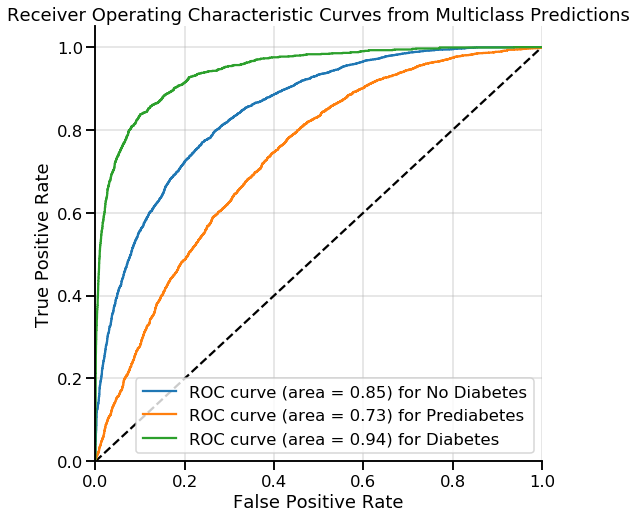

In [93]:
from sklearn.multiclass import OneVsRestClassifier
estimator = AdaBoostClassifier(random_state=0)
roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
plot_multiclass_roc_df(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

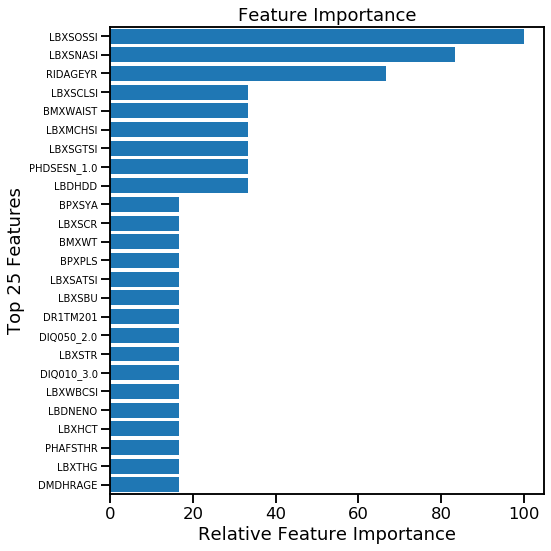

In [94]:
# What features are important to the Adaboost model?
plot_top_features_imp(a_clf, X_train_tree_df, 25)

#### Top features: 
LBXSOSSI = Osmolality (mmol/Kg)  
LBXSNASI = Sodium (mmol/L)  
RIDAGEYR = Age (yr)  
LBXSCLSI = Chloride (mmol/L)  
BMXWAIST = Waist circumference (cm)  
LBXMCHSI = Mean cell hemoglobin (pg)  
LGXSGTSI = Gamma glutamyl transferase (U/L)  
PHDSESN_1.0 = Examination session = Morning  
LBDHDD = Direct HDL-Cholesterol (mg/dL)  
BYXSYA = Systolic blood pressure (mm Hg)  

#### Adaboost is better than untuned Random Forest, but not the tuned version.  

### e. Gradient Boosting

In [95]:
# Use default parameters. 
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=2)
gb_clf.fit(X_train_tree_df, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [96]:
y_pred = gb_clf.predict(X_test_tree_df)

In [97]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.583, 0.312, 0.105])

In [98]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.717 



In [99]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(gb_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 71.983% (0.262%)


In [100]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4361,  841,   36],
       [1246, 1836,  198],
       [  73,  365,  786]], dtype=int64)

In [101]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.77      0.83      0.80      5238
 Prediabetes       0.60      0.56      0.58      3280
    Diabetes       0.77      0.64      0.70      1224

    accuracy                           0.72      9742
   macro avg       0.71      0.68      0.69      9742
weighted avg       0.71      0.72      0.71      9742



In [102]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.71, Prediabetes: 0.81, Diabetes: 0.97


(9742, 3) (9742, 3)


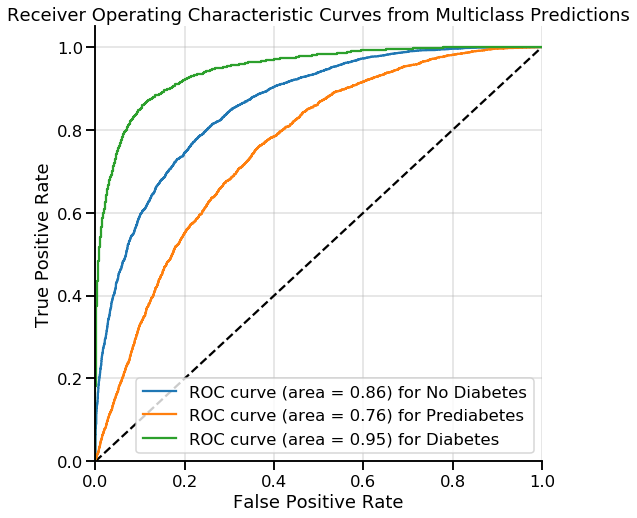

In [103]:
from sklearn.multiclass import OneVsRestClassifier
estimator = GradientBoostingClassifier(random_state=2)
roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
plot_multiclass_roc_df(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

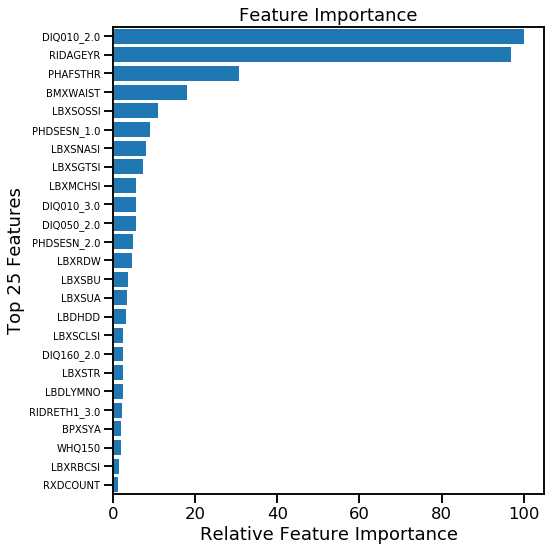

In [104]:
# What features are important to the Gradient Boosting model?
plot_top_features_imp(gb_clf, X_train_tree_df, 25)

#### Top features: 
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
RIDAGEYR = Age (yr)  
PHAFSTHR = Total fasting time before blood draw for labs (hr)  
BMXWAIST = Waist circumference (cm)  
LBXSOSSI = Osmolality (mmol/Kg)  
PHDSESN_1.0 = Examination session = Morning  
LBXSNASI = Sodium (mmol/L)  
LGXSGTSI = Gamma glutamyl transferase (U/L)  
LBXMCHSI = Mean cell hemoglobin (pg)  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  

#### Gradient Boosting looks similar in performace to the tuned Random Forest. 

### f. XGBoost

In [105]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [106]:
# Start with default parameters. 
xgb_clf = XGBClassifier(objectibe='multi:softmax', num_class=3, random_state=0)
xgb_clf.fit(X_train_tree_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objectibe='multi:softmax',
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [107]:
y_pred = xgb_clf.predict(X_test_tree_df)

In [108]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.588, 0.311, 0.102])

In [109]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.712 



In [110]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(xgb_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 71.697% (0.457%)


In [111]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4375,  825,   38],
       [1274, 1810,  196],
       [  78,  391,  755]], dtype=int64)

In [112]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.76      0.84      0.80      5238
 Prediabetes       0.60      0.55      0.57      3280
    Diabetes       0.76      0.62      0.68      1224

    accuracy                           0.71      9742
   macro avg       0.71      0.67      0.68      9742
weighted avg       0.71      0.71      0.71      9742



In [113]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.7, Prediabetes: 0.81, Diabetes: 0.97


(9742, 3) (9742, 3)


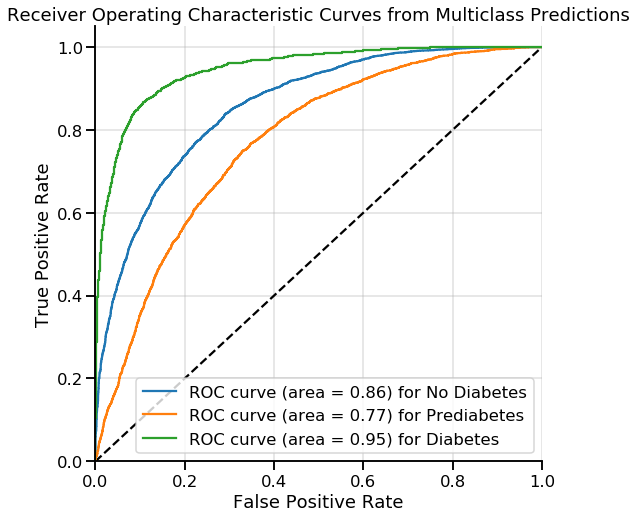

In [114]:
from sklearn.multiclass import OneVsRestClassifier
estimator = XGBClassifier(random_state=0, objective='multi:softprob', num_class=3)
roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
plot_multiclass_roc_pr(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

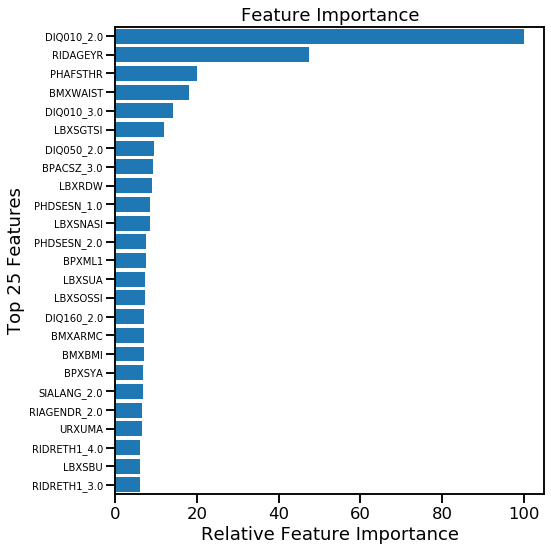

In [115]:
# What features are important to the XGBoost model?
plot_top_features_imp(xgb_clf, X_train_tree_df, 25)

#### Top features:   
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
RIDAGEYR = Age (yr)  
PHAFSTHR = Total fasting time before blood draw for labs (hr)  
BMXWAIST = Waist circumference (cm)  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
LBXSGTSI = Gamma glutamyl transferase (U/L)  
DIQ050_2.0 = Taking insulin now = NO  
BPACSZ_3.0 = Blood pressure cuff size = Adult  
LBXRDW = Red cell distribution width (%)  
PHDSESN_1.0 = Examination session = morning  


#### Now tune the XGBoost model. 

In [116]:
# Tune XGBoost model with RandomizedSearchCV. 
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score

xgb_clf = XGBClassifier(objective = 'multi:softmax', num_class=3, random_state=0)
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'gamma': [0, .1, .2, .3, .4, .5],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(xgb_clf, param_distributions = param_dist, cv=5, n_iter=15, n_jobs=-1, random_state=0)
clf.fit(X_train_tree_df, y_train)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None, num_class=3,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_l...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001398C7C4A48>,
                                        'max

In [117]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8502554669116591,
              gamma=0.3, learning_rate=0.03581076194626749, max_delta_step=0,
              max_depth=8, min_child_weight=3, missing=None, n_estimators=406,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7359922668826686,
              verbosity=1)

In [118]:
clf.best_params_

{'colsample_bytree': 0.8502554669116591,
 'gamma': 0.3,
 'learning_rate': 0.03581076194626749,
 'max_depth': 8,
 'min_child_weight': 3,
 'n_estimators': 406,
 'subsample': 0.7359922668826686}

In [119]:
# Fit single classifier with optimal parameters so we can get feature importance. 
params = clf.best_params_
xgb_clf =  XGBClassifier(objective='multi:softmax', num_class=2, random_state=0)
xgb_clf.set_params(**params)
xgb_clf.fit(X_train_tree_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8502554669116591,
              gamma=0.3, learning_rate=0.03581076194626749, max_delta_step=0,
              max_depth=8, min_child_weight=3, missing=None, n_estimators=406,
              n_jobs=1, nthread=None, num_class=2, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7359922668826686,
              verbosity=1)

In [120]:
y_pred = xgb_clf.predict(X_test_tree_df)

In [121]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.573, 0.327, 0.1  ])

In [122]:
# Accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.728 



In [123]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(xgb_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 72.823% (0.529%)


In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4364,  850,   24],
       [1168, 1947,  165],
       [  52,  390,  782]], dtype=int64)

In [125]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Prediabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.78      0.83      0.81      5238
 Prediabetes       0.61      0.59      0.60      3280
    Diabetes       0.81      0.64      0.71      1224

    accuracy                           0.73      9742
   macro avg       0.73      0.69      0.71      9742
weighted avg       0.73      0.73      0.73      9742



In [126]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. Use 
#    multilabel_confusion_matrix output as it already has combined values from other classes. 
from sklearn.metrics import multilabel_confusion_matrix
multi_conf_ma = multilabel_confusion_matrix(y_test, y_pred)
specificity = np.empty(3)
specificity = np.round(multi_conf_ma[:, 0, 0] / (multi_conf_ma[:, 0, 0] + multi_conf_ma[:, 0, 1]), 2)
print(f"Specificity: No Diabetes: {specificity[0]}, Prediabetes: {specificity[1]}, Diabetes: {specificity[2]}")

Specificity: No Diabetes: 0.73, Prediabetes: 0.81, Diabetes: 0.98


(9742, 3) (9742, 3)


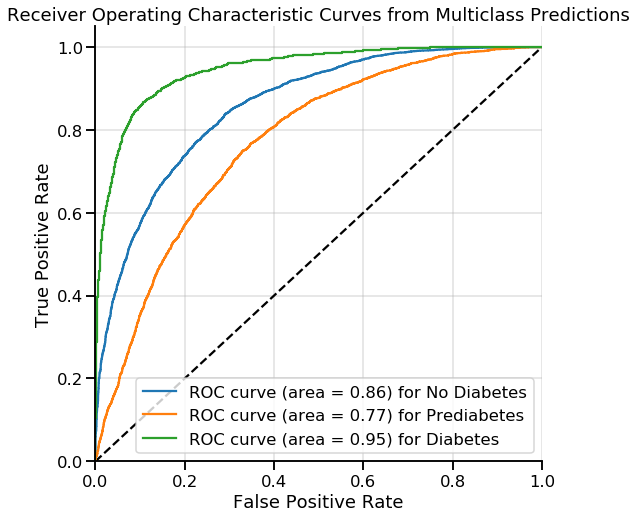

In [127]:
from sklearn.multiclass import OneVsRestClassifier
estimator = XGBClassifier(random_state=0, objective='multi:softprob', num_class=3)
roc_clf = OneVsRestClassifier(estimator).fit(X_train_tree_df, y_train)
plot_multiclass_roc_pr(roc_clf, X_test_tree_df, y_test, n_classes=3, figsize=(8, 8))

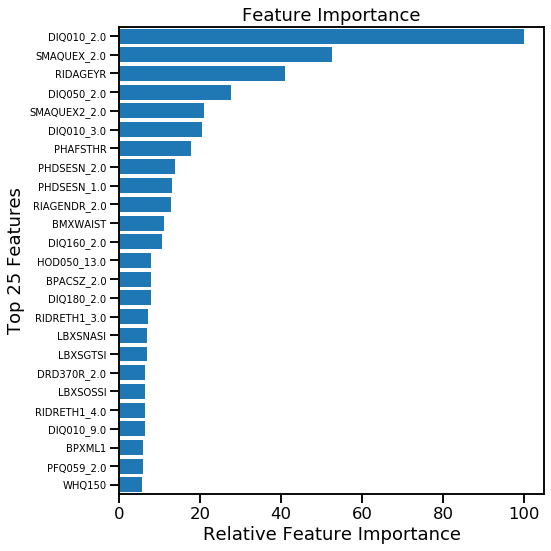

In [128]:
# What features are important to the XGBoost model?
plot_top_features_imp(xgb_clf, X_train_tree_df, 25)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
SMAQUEX_2.0 = Smoking recent use questionnaire flag = >= 18 yrs old  
RIDAGEYR = Age (yr)  
DIQ050_2.0 = Taking insulin now = NO  
SMAQUEX2_2.0 = Smoking cigarette use questionnaire flag = 12-17 yrs old  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
PHAFSTHR = Total fasting time before blood draw for labs (hr)  
PHDSESN_2.0 = Examination session = afternoon  
PHDSESN_1.0 = Examination session = morning  
RIAGENDR_2.0 = Gender = Female  

#### Tuned XGBoost is clearly the best tree-based model. It would be interesting to tune the Logistic Regression model and see how it compared. 

#### Summary of pre-tuning results:

| Model | Accuracy (test) | Accuracy (5-fold cv train) | Precision | Recall/Sensitivity | Specificity | F1-Score | ROC AUC |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | .715 | 71.7 (.274) | .58 | .63 | .77 | .60 | .74 |
| Decision Tree | .597 | 60.1 (.381) | .45 | .46 | .72 | .46 | .60 |
| Random Forest | .674 | 67.3 (.540) | .55 | .47 | .80 | .50 | .74 |
| Adaboost | .705 | 70.5 (.317) | .59 | .53 | .81 | .56 | .73 |
| Gradient Boosting | .717 | 72.0 (.262) | .60 | .56 | .81 | .58 | .76 |
| XGBoost | .712 | 71.7 (.457) | .60 | .55 | .81 | .57 | .77 |

#### Post-tuning:

| Model | Accuracy (test) | Accuracy (5-fold cv train) | Precision | Recall/Sensitivity | Specificity | F1-Score | ROC AUC |
| ---| --- | --- | --- | --- | --- | --- | --- |
| Random Forest | .702 | 70.7 (.584) | .57 | .60 | .78 | .59 | .76 |
| XGBoost | .728 | 72.8 (.529) | .61 | .59 | .81 | .60 | .77 |

#### Note: Accuracy is for overall model. All other measures are for Prediabetes class. 
#### As this is medical data, reported Sensitivity & Specificity in addition to Precision & Recall.

## II. Models with target = ICD-10 code (subset of data = 4 yrs)

In [129]:
def set_icd(df, seqn):
    """
    Return integer indicator for diabetes diagnosis criteria or NaN if no test results found.
        2 = Diabetes
        1 = Prediabetes
        0 = No Diabetes
        NaN = No test results found
        
    Criteria: ICD-10 codes for diabetes and prediabetes: 
               E11*: Diabetes, 
               R73* and no E11*: Elevated Blood Sugar = Prediabetes,
               no R73* and no E11*: No Diabetes or Prediabetes
    
    Input:  df, dataframe containing SEQN identifiers and ICD-10 code data. 
            seqn, unique participant identifier used to lookup ICD-10 codes. 
    """
    rows = df[df['SEQN'] == seqn]
       
    # E11 is base code for diabetes. Check for this first as some participants have codes for diabetes and 
    #    elevated blood sugar. These participants go in Diabetes Med category. 
    if (rows['RXDRSC1'].str.contains('E11', regex=False).any()) \
                or (rows['RXDRSC2'].str.contains('E11', regex=False).any()) \
                or (rows['RXDRSC3'].str.contains('E11', regex=False).any()):
        return 2
    # R73 is base code for Elevated Blood Sugar, which is Prediabetes in the absence of a Diabetes diagnosis. 
    elif (rows['RXDRSC1'].str.contains('R73', regex=False).any()) \
                or (rows['RXDRSC2'].str.contains('R73', regex=False).any()) \
                or (rows['RXDRSC3'].str.contains('R73', regex=False).any()):
        return 1
    else:
        return 0
    

# Only keep rows that contain ICD-10 codes. 
icd_meds = meds[meds.RXDRSC1.notnull() | meds.RXDRSC2.notnull() | meds.RXDRSC3.notnull()].copy()
meds_seqn = icd_meds.SEQN.unique()

for seqn in meds_seqn:
    icd_meds.loc[icd_meds['SEQN'] == seqn, 'ICDDIAB'] = set_icd(icd_meds, seqn) 
icd_meds.ICDDIAB.value_counts()

0.0    19225
2.0     7652
1.0      740
Name: ICDDIAB, dtype: int64

In [130]:
# Use only: 
#             SEQN: unique identifier, 
#             RXDUSE: Do you use prescription medications?, 
#             RXDCOUNT: How many prescriptions do you take?, 
#             ICDDIAB: target
#      from meds dataframe. All others have a many to one relationship with target feature. Need to use OneHotEncoder 
#     if keeping them as features but there are 1115 different medications. That is a lot of features with
#     very sparse data. 

ml_meds = icd_meds[['SEQN', 'ICDDIAB', 'RXDUSE', 'RXDCOUNT']].drop_duplicates()
ml_meds.shape

(7990, 4)

In [131]:
ml_meds.ICDDIAB.value_counts()

0.0    6585
2.0    1260
1.0     145
Name: ICDDIAB, dtype: int64

In [132]:
# Determine cutoff for dropping columns with too many null values. 

n_ICDDIAB = ml_meds[ml_meds.ICDDIAB.notnull()]['ICDDIAB'].count()
null_cutoff = int(n_ICDDIAB * .4)
print(f"Number of ICD DIAB codes: {n_ICDDIAB}\n40% of ICD DIAB codes: {null_cutoff}")

Number of ICD DIAB codes: 7990
40% of ICD DIAB codes: 3196


In [133]:
# Merge all dataframes into one by combining on SEQN, unique participant identification number. 

full_data = ml_meds.merge(demo, on='SEQN', how='left')
full_data = full_data.merge(diet, on='SEQN', how='left')
full_data = full_data.merge(exam, on='SEQN', how='left')
full_data = full_data.merge(labs, on='SEQN', how='left')
full_data = full_data.merge(ques, on='SEQN', how='left')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7990 entries, 0 to 7989
Columns: 876 entries, SEQN to WHQ520
dtypes: float64(862), int32(12), object(2)
memory usage: 53.1+ MB


In [134]:
# Modify some features that are continuous but also have categorical markers. Remove the categories so they can be 
#    modeled as continuous. 
# Change 777, 7777, 999, and 9999 values to NaN as they could confuse model. These represent "refused to answer" and 
#    "don't know". Change 5555 to 21 as it represents "over 21". 
full_data.replace({'WHD050':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'WHD110':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'WHD120':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'WHD140':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'WHQ150':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'PAD680':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'ALQ120Q':{777:np.nan,999:np.nan}},inplace=True)
full_data.replace({'DBD895':{5555:21,7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'DBD900':{5555:21,7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'DBD905':{7777:np.nan,9999:np.nan}},inplace=True)
full_data.replace({'DBD910':{7777:np.nan,9999:np.nan}},inplace=True)

In [135]:
# Create boolean mask of columns to keep by finding those with # of null values below cutoff value.
cols_to_keep = full_data.isna().sum() < null_cutoff
ml_data = full_data.iloc[:, cols_to_keep.values].copy()

In [136]:
# How much data is left?
ml_data.shape

(7990, 326)

In [137]:
# Verify no duplicate rows for any SEQNs. 
ml_data.SEQN.nunique()

7990

In [138]:
# Make sure we have a target for each observation. 
ml_data.ICDDIAB.isnull().sum()

0

In [139]:
# Check for string data. No string data left. 
ml_data.dtypes.value_counts()

float64    314
int32       12
dtype: int64

In [140]:
# Which/how many columns have null values?

ml_data.columns[ml_data.isnull().sum().values > 0]

Index(['DMDCITZN', 'DMDEDUC2', 'DMDHREDU', 'DMDHRMAR', 'DMDMARTL', 'FIAINTRP',
       'FIALANG', 'FIAPROXY', 'INDFMIN2', 'INDFMPIR',
       ...
       'WHD010', 'WHD020', 'WHQ030', 'WHQ040', 'WHD050', 'WHQ070', 'WHD110',
       'WHD120', 'WHD140', 'WHQ150'],
      dtype='object', length=302)

In [141]:
# Average the three Systolic and Diastolic Blood Pressures and save average, drop individual measurements. 
ml_data = ml_data.assign(BPXSYA = ml_data[['BPXSY1', 'BPXSY2', 'BPXSY3']].mean(axis=1), 
                         BPXDIA = ml_data[['BPXDI1', 'BPXDI2', 'BPXDI3']].mean(axis=1))
ml_data = ml_data.drop(['BPXSY1', 'BPXSY2', 'BPXSY3', 'BPXDI1', 'BPXDI2', 'BPXDI3'], axis=1)

In [142]:
# Categorize features for preprocessing: continuous, categorical ordinal, categorical nominal
cont_cols = ['DR1DBIH', 'DR1DAY', 'DR1TNUMF','DR1TKCAL', 'DR1TPROT', 
                 'DR1TCARB', 'DR1TSUGR', 'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 
                 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL', 'DR1TATOC', 'DR1TATOA', 'DR1TRET', 'DR1TVARA', 'DR1TACAR', 
                 'DR1TBCAR', 'DR1TCRYP', 'DR1TLYCO', 'DR1TLZ', 'DR1TVB1', 'DR1TVB2', 'DR1TNIAC', 'DR1TVB6', 'DR1TFOLA', 
                 'DR1TFA', 'DR1TFF', 'DR1TFDFE', 'DR1TCHL', 'DR1TVB12', 'DR1TB12A', 'DR1TVC', 'DR1TVD', 'DR1TVK', 
                 'DR1TCALC', 'DR1TPHOS', 'DR1TMAGN', 'DR1TIRON', 'DR1TZINC', 'DR1TCOPP', 'DR1TSODI', 'DR1TPOTA', 
                 'DR1TSELE', 'DR1TCAFF', 'DR1TTHEO', 'DR1TALCO', 'DR1TMOIS', 'DR1TS040', 'DR1TS060', 'DR1TS080', 
                 'DR1TS100', 'DR1TS120', 'DR1TS140', 'DR1TS160', 'DR1TS180', 'DR1TM161', 'DR1TM181', 'DR1TM201', 
                 'DR1TM221', 'DR1TP182', 'DR1TP183', 'DR1TP184', 'DR1TP204', 'DR1TP205', 'DR1TP225', 'DR1TP226', 
                 'DR1_320Z', 'DR1_330Z', 'DR1BWATZ',  
                 'BPXPLS', 'BPXML1', 'BPXSYA', 'BPXDIA', 'BMXWT', 
                 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC', 'BMXWAIST', 'URXUMA', 'URXUCR',  
                 'LBXSAL', 'LBXSAPSI', 'LBXSASSI', 'LBXSATSI', 'LBXSBU', 'LBXSC3SI', 'LBXSCA', 
                 'LBXSCLSI', 'LBXSCR', 'LBXSGB', 'LBXSGTSI', 'LBXSIR', 'LBXSKSI', 'LBXSLDSI', 'LBXSNASI', 
                 'LBXSOSSI', 'LBXSPH', 'LBXSTB', 'LBXSTP', 'LBXSTR', 'LBXSUA', 'LBXWBCSI', 'LBXLYPCT', 'LBXMOPCT', 
                 'LBXNEPCT', 'LBXEOPCT', 'LBXBAPCT', 'LBDLYMNO', 'LBDMONO', 'LBDNENO', 'LBDEONO', 'LBDBANO', 'LBXRBCSI', 
                 'LBXHGB', 'LBXHCT', 'LBXMCVSI', 'LBXMCHSI', 'LBXRDW', 'LBXPLTSI', 'LBXMPSI', 'PHAFSTHR', 'PHAFSTMN', 
                 'LBDHDD', 'LBXTC', 'RXDCOUNT', 'RIDAGEYR', 'DMDHHSIZ', 'DMDFMSIZ',
                 'DMDHRAGE', 'INDFMPIR', 'INDFMMPI', 'WHD050', 'WHD110', 'WHD120', 'WHD140', 'WHQ150', 'PAD680', 
                 'ALQ120Q', 'LBXGH', 'LBXSGL', 'DBD895', 'DBD900', 'DBD905', 'DBD910']
cat_ord_cols = []
cat_nom_cols = ['SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDRETH1', 'RIDEXMON', 
                    'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'SIALANG', 'SIAPROXY', 
                    'SIAINTRP', 'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG', 'MIAPROXY', 'MIAINTRP', 
                    'DMDHRGND', 'DMDHREDU', 'DMDHRMAR', 'INDHHIN2', 
                    'INDFMIN2', 'DR1DRSTZ', 'DRABF', 'DR1LANG', 'DRDINT', 'DBQ095Z', 
                    'DRQSPREP', 'DRQSDIET', 'DR1_300', 'DR1TWS', 'DRD340', 
                    'DRD360', 
                    'BPAARM', 
                    'BPACSZ', 'BPXPULS', 'BPXPTY', 'BPAEN1', 'BPAEN2', 'BPAEN3', 'BMDSTATS', 'PHQ020', 'PHQ030', 
                    'PHQ040', 'PHQ050', 'PHQ060', 'LBXHA', 'LBXHBS', 'LBXHBC',   
                    'ALQ101', 'BPQ020', 'BPQ070', 'BPQ080', 'HSAQUEX', 'HSD010', 
                    'HSQ500', 'HSQ510', 'HSQ520', 'HSQ571', 'HSQ590', 'DIQ010', 'DIQ160', 'DIQ170', 'DIQ180', 
                    'DIQ050', 'DBQ700', 'DBQ197', 'DBQ229',  
                    'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070',
                    'DPQ080', 'DPQ090', 'HIQ011', 'HIQ270', 'HIQ210', 'HOD050', 
                    'HOQ065', 'HUQ010', 'HUQ020', 'HUQ030', 'HUQ071', 'HUQ090', 'IMQ011', 'IMQ020', 'INQ020', 'INQ012',
                    'INQ030', 'INQ060', 'INQ080', 'INQ090', 'INQ132', 'INQ140', 'INQ150', 'IND235', 
                    'INDFMMPC', 'MCQ010', 'MCQ053', 'MCQ080', 'MCQ092', 'MCQ160A', 'MCQ160N', 'MCQ160B', 'MCQ160C', 
                    'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ160G', 'MCQ160M', 'MCQ160K', 'MCQ160L', 'MCQ220', 'MCQ300A', 
                    'MCQ300B', 'MCQ300C', 'OCD150', 'OCD390G', 'PFQ049', 'PFQ051', 'PFQ054', 'PFQ057',  
                    'PFQ090', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ650', 'PAQ665', 'SLQ050', 'SMQ020', 'SMAQUEX2', 
                    'WHQ030', 'WHQ040', 'WHQ070', 
                    'SMAQUEX', 'RXDUSE', 'PHDSESN', 'CDQ001', 'CDQ010', 'BPQ090D', 'LBXHCR']


In [143]:
# Check that columns are in data. Some columns were dropped in data wrangling step. 
[print(f"No {col} in ml_data.") for col in cont_cols if col not in ml_data.columns]
print("\n")
[print(f"No {col} in ml_data.") for col in cat_nom_cols if col not in ml_data.columns]     

[]

In [144]:
# Get rid of duplicate columns (same data converted to different units) as they will be perfectly correlated. 
#    Drop WHD020 as it is highly correlated with BMXWT, WHD010 as it is highly correlatied with BMXHT. 
#    Drop survey weights and survey analysis parameters as they are moot to diabetes/prediabetes predictions. 
#    Drop DIAB column as it was target for part I of analysis. 
#    Drop DR1EXMER as it is examiner ID and is moot to diabetes prediction. 
dup_cols = ['URXUMS', 'URXCRS',
            'LBDSALSI', 'LBDSBUSI', 'LBDSCASI', 'LBDSCHSI', 'LBDSCRSI', 'LBDSGBSI', 'LBDSGLSI', 'LBDSIRSI', 
            'LBDSPHSI', 'LBDSTBSI', 'LBDSTPSI', 'LBDSTRSI', 'LBDSUASI', 'LBDHDDSI', 'LBDTCSI',  
            'LBXSCH', 'WHD010', 'WHD020', 
            'WTINT2YR', 'WTMEC2YR', 'WTDRD1', 'WTDR2D', 'SDMVPSU', 'SDMVSTRA', 'DIAB', 'DR1EXMER']
ml_data = ml_data.drop(dup_cols, axis=1)

In [145]:
# Make sure we have accounted for all columns and haven't overlooked any. 
missing_cols = list(set(ml_data.columns) - set(cont_cols) - set(cat_ord_cols) - set(cat_nom_cols) - set(dup_cols) \
                    - set(('SEQN', 'ICDDIAB')))
print(missing_cols)

[]


In [146]:
# Divide data into train and test before preprocessing to avoid leakage. Stratify on ICDDIAB target indicator. Do not 
#    include SEQN in features as it is just a unique participant identifier. 
from sklearn.model_selection import train_test_split

X = ml_data.drop(['ICDDIAB', 'SEQN'], axis=1)
y = ml_data.ICDDIAB
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42, stratify=y)

# How big are our train and test sets?
print(f"Train features: {X_train.shape}\nTrain targets:  {y_train.shape}\nTest features:  {X_test.shape}",
      f"\nTest targets:   {y_test.shape}")

Train features: (5593, 292)
Train targets:  (5593,)
Test features:  (2397, 292) 
Test targets:   (2397,)


In [147]:
def class_proportion(target_col):
    """
    Check proportion of values of Series. 
    
    Return: 
            dict of {value: proportion} for each value in input Series
            
    Input:
            pandas Series
    """
    grp = target_col.value_counts()
    return {idx: round(val/len(target_col), 3) for idx, val in grp.items()}
print(f"Original data target class proportion: {class_proportion(ml_data['ICDDIAB'])}")
print(f"Training data target class proportion: {class_proportion(pd.Series(y_train))}")
print(f"Test data target class proportion:     {class_proportion(pd.Series(y_test))}")

Original data target class proportion: {0.0: 0.824, 2.0: 0.158, 1.0: 0.018}
Training data target class proportion: {0.0: 0.824, 2.0: 0.158, 1.0: 0.018}
Test data target class proportion:     {0.0: 0.824, 2.0: 0.158, 1.0: 0.018}


#### The proportion of participants taking medication for diabetes is very close to the proportion meeting the lab criteria for diabetes in part I.  

#### Note: These participants taking medication for diabetes may not be the same participants meeting lab criteria as those taking medication may have lab results below the diagnostic threshold.  

#### The proportion of participants taking medication for prediabetes is very tiny most likely because it is usually treated with lifestyle and diet, not medication.  



In [148]:
# Change class labels of 1.0 to 0.0. Not much data for prediabetes class. Ignore R73 ICD-code and just classify based on 
#    E11. 
# Caution: only run this once or all the E11 observations will be changed from 1.0 to 0.0 due to following cell. 
y_train[y_train == 1.0] = 0.0
y_test[y_test == 1.0] = 0.0

In [149]:
# In order not to confuse algorithms with labels of 0 and 2 for a binary problem, change 2.0 values to 1.0. 
y_train[y_train == 2.0] = 1.0
y_test[y_test == 2.0] = 1.0

In [150]:
print(f"Original data target class proportion: {class_proportion(ml_data['ICDDIAB'])}")
print(f"Training data target class proportion: {class_proportion(pd.Series(y_train))}")
print(f"Test data target class proportion:     {class_proportion(pd.Series(y_test))}")

Original data target class proportion: {0.0: 0.824, 2.0: 0.158, 1.0: 0.018}
Training data target class proportion: {0.0: 0.842, 1.0: 0.158}
Test data target class proportion:     {0.0: 0.842, 1.0: 0.158}


In [151]:
# Fill null values with imputed values. Use IterativeImputer again.
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

#Limit nearest features so compute time is reasonable. 
imp = IterativeImputer(n_nearest_features=5, random_state=42)

X_train_filled = pd.DataFrame(imp.fit_transform(X_train))
X_train_filled.columns = X_train.columns

C:\Users\tracy\Anaconda3\envs\capstone1\lib\site-packages\sklearn\impute\_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [152]:
# Fill nulls in test data with fit from training data. 
X_test_filled = pd.DataFrame(imp.transform(X_test))
X_test_filled.columns = X_test.columns

In [153]:
# Scale continuous features for better model convergence. 
# Note: output of StandardScaler is np.array. Convert back to DataFrame to do pd.concat with rest of features. 
# StandardScaler output is only columns that were transformed, not rest of dataframe. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_X_train_cont = pd.DataFrame(scaler.fit_transform(X_train_filled[cont_cols]))
scaled_X_test_cont = pd.DataFrame(scaler.transform(X_test_filled[cont_cols]))
# Give DataFrames column names and set indexes to original indexes. Needs to match index of other features for 
#    correct pd.concat processing. 
scaled_X_train_cont.columns = cont_cols
scaled_X_train_cont.index = X_train.index
scaled_X_test_cont.columns = cont_cols
scaled_X_test_cont.index = X_test.index
print(f"Size of train set: {scaled_X_train_cont.shape}, Size of test set: {scaled_X_test_cont.shape}")

Size of train set: (5593, 148), Size of test set: (2397, 148)


In [154]:
# Convert categorical nominal features to dummy variables for modeling. Round nominal features from filled dataframe 
#    before converting as imputer filled with continuous values between min and max of original data. Rounding 
#    brings imputed continuous values to integer categories.   
from pandas.api.types import CategoricalDtype

X_train_dummy = round(X_train_filled.loc[:,cat_nom_cols], 0).apply(lambda x: x.astype('category'))
# Get categories from train set to define categories in test set. 
X_train_cats = {col: CategoricalDtype(categories=X_train_dummy[col].cat.categories.to_list()) \
                for col in X_train_dummy.columns}
# Now convert category column to dummy variables for modeling. Drop_first as most add up to 1 - don't want to 
#    cause problem with regression model. 
X_train_dummy = pd.get_dummies(X_train_dummy, drop_first=True)
X_train_dummy.index = X_train.index

# Use train categories on test data. Will drop any values not in category list. 
X_test_dummy = round(X_test_filled.loc[:,cat_nom_cols], 0)
 
X_test_dummy = X_test_dummy.astype(X_train_cats)
X_test_dummy = pd.get_dummies(X_test_dummy, columns=cat_nom_cols, drop_first=True)
X_test_dummy.index = X_test.index

# Get columns from training that are missing in test as fewer values in test for get_dummies.
missing_cols = set(X_train_dummy.columns) - set(X_test_dummy.columns)
# Add each missing column to test set with value equal to 0.
for c in missing_cols:
    X_test_dummy[c] = 0
# Ensure the order of columns in the test set is the same as in train set.
X_test_dummy = X_test_dummy[X_train_dummy.columns]

print(f"Size of categorical nominal features: train: {X_train_dummy.shape}, test: {X_test_dummy.shape}")

Size of categorical nominal features: train: (5593, 466), test: (2397, 466)


In [155]:
# Pull out categorical ordinal data to concatenate into features DataFrame. 
X_train_cat_ord = X_train_filled.loc[:, cat_ord_cols]
X_test_cat_ord = X_test_filled.loc[:, cat_ord_cols]
X_train_cat_ord.index = X_train.index
X_test_cat_ord.index = X_test.index
print(f"Size of categorical ordinal features: train: {X_train_cat_ord.shape}, test: {X_test_cat_ord.shape}")

Size of categorical ordinal features: train: (5593, 0), test: (2397, 0)


In [156]:
X_train_processed_df = pd.concat([scaled_X_train_cont, X_train_dummy, X_train_cat_ord], axis=1)
X_test_processed_df = pd.concat([scaled_X_test_cont, X_test_dummy, X_test_cat_ord], axis=1)
print(f"Size of feature set: train: {X_train_processed_df.shape}, test: {X_test_processed_df.shape}")

Size of feature set: train: (5593, 614), test: (2397, 614)


In [157]:
# Convert dataframes to numpy arrays for modeling. 
X_train_processed = np.array(X_train_processed_df)
X_test_processed = np.array(X_test_processed_df)
y_train = np.array(y_train).squeeze()
y_test = np.array(y_test).squeeze()
print(X_train_processed.shape, y_train.shape)

(5593, 614) (5593,)


### a. Logistic Regression

In [158]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=0, class_weight='balanced', 
                           max_iter=2000, multi_class='auto').fit(X_train_processed, y_train)

In [159]:
y_pred = lr_clf.predict(X_test_processed)

In [160]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.816, 0.184])

In [161]:
pred_prob = lr_clf.predict_proba(X_test_processed)

In [162]:
# Overall accuracy from test dataset. 
accuracy = lr_clf.score(X_test_processed, y_test)
print(f"Overall model accuracy: {accuracy}")

Overall model accuracy: 0.934918648310388


In [163]:
# Check accuracy with 5-fold cross validation. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(lr_clf, X_train_processed, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 93.813% (0.723%)


In [164]:
precision, recall, fscore, target_count = precision_recall_fscore_support(y_test, y_pred, average=None)
print(f"Prediabetes Precision: {np.round(precision[1],3)}, Recall: {np.round(recall[1], 3)}, F-score: {np.round(fscore[1], 3)}")

Prediabetes Precision: 0.752, Recall: 0.876, F-score: 0.809


In [165]:
# Confusion matrix: actual is rows, predicted is columns. 0,0 top left; 2,2 bottom right. 
#    Lots of actual prediabetes predicted no diabetes; actual no diabetes predicted prediabetes. 
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1910,  109],
       [  47,  331]], dtype=int64)

In [166]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes','Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.98      0.95      0.96      2019
    Diabetes       0.75      0.88      0.81       378

    accuracy                           0.93      2397
   macro avg       0.86      0.91      0.89      2397
weighted avg       0.94      0.93      0.94      2397



In [167]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.95


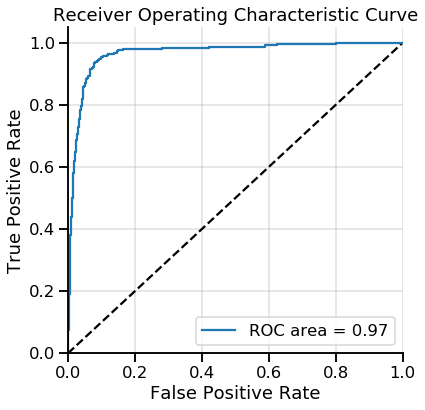

In [168]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_df(clf, X_test, y_test, figsize=(12, 6)):
    """
    Plot roc and calculate roc_auc for binary model supporting .decision_function().
    
    Input: 
        clf: Trained  binary Classifier
        X_test: Test feature dataset to be used to get prediction probabilities for classifier
        y_test: True class values for test features in shape [n_samples,]
        figsize: Figure size of plot, optional
    """
    y_score = clf.decision_function(X_test)

    # labels
    labels = ['No Diabetes', 'Diabetes']

    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1.0)
    roc_auc = auc(fpr, tpr)

    # plot roc 
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curve')
    ax.plot(fpr, tpr, label='ROC area = %0.2f' % (roc_auc))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_roc_df(lr_clf, X_test_processed, y_test, figsize=(6, 6)) 

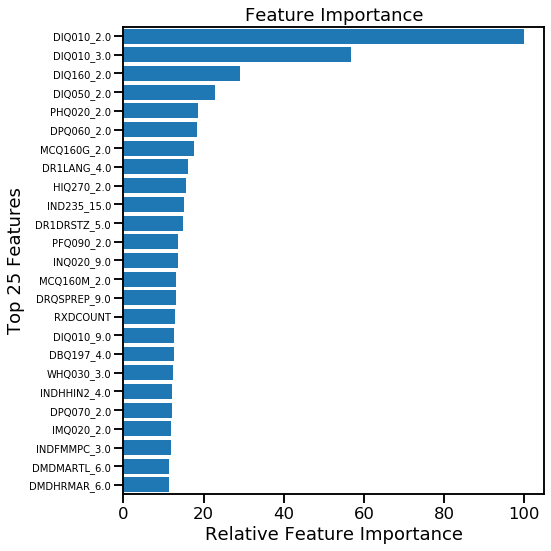

In [169]:
plot_top_features_coef(lr_clf, X_train_processed_df, 25, 0)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
DIQ160_2.0 = Doctor ever said you have prediabetes = NO  
DIQ050_2.0 = Taking insulin now = NO  
PHQ020_2.0 = Have you had coffee or tea with cream or sugar during fasting time = NO  
DPQ060_2.0 = Over the last two weeks, how often have you felt bad about yourself = More than half the days  
MCQ160G_2.0 = Ever told you had emphysema = NO  
DR1LANG_4.0 = Language used mostly = Other  
HIQ270_2.0 = Does your insurance cover prescriptions = NO  
IND235_15.0 = Monthly family income = Other  

#### Logistic Regression is much better at predicting diabetes than predicting prediabetes! The Precision could have been a bit better but Recall is good. The ROC curve shows this is a pretty good model. 

### b. Decision Tree

In [170]:
# No need to use scaled data for decision tree. 
# Pull out continuous data to concatenate with dummies. 
X_train_cont = X_train_filled.loc[:, cont_cols]
X_test_cont = X_test_filled.loc[:, cont_cols]
X_train_cont.index = X_train.index
X_test_cont.index = X_test.index
# Need to use dummy variables for sklearn decision trees. 
X_train_tree_df = pd.concat([X_train_cont, X_train_dummy, X_train_cat_ord], axis=1)
X_test_tree_df = pd.concat([X_test_cont, X_test_dummy, X_test_cat_ord], axis=1)
print(f"Size of feature set: train: {X_train_tree_df.shape}, test: {X_test_tree_df.shape}")

Size of feature set: train: (5593, 614), test: (2397, 614)


In [171]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=0, class_weight='balanced')
dt_clf.fit(X_train_tree_df, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [172]:
y_pred = dt_clf.predict(X_test_tree_df)

In [173]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.841, 0.159])

In [174]:
# Get accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.928 



In [175]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(dt_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 91.972% (0.576%)


In [176]:
precision, recall, fscore, target_count = precision_recall_fscore_support(y_test, y_pred, average=None)
print(f"Prediabetes Precision: {np.round(precision[1],3)}, Recall: {np.round(recall[1], 3)}, F-score: {np.round(fscore[1], 3)}")

Prediabetes Precision: 0.77, Recall: 0.778, F-score: 0.774


In [177]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1931,   88],
       [  84,  294]], dtype=int64)

In [178]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.96      0.96      0.96      2019
    Diabetes       0.77      0.78      0.77       378

    accuracy                           0.93      2397
   macro avg       0.86      0.87      0.87      2397
weighted avg       0.93      0.93      0.93      2397



In [179]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.96


In [180]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_pr(clf, X_test, y_test, figsize=(12, 6)):
    """
    Plot roc and calculate roc_auc for binary model supporting .predict_proba().
    
    Input:      
        clf: Trained  binary Classifier
        X_test: Test feature dataset to be used to get prediction probabilities for classifier
        y_test: True class values for test features in shape [n_samples,]
        figsize: Figure size of plot, optional
    """
    y_score = clf.predict_proba(X_test)

    # labels
    labels = ['No Diabetes', 'Diabetes']

    # calculate roc, auc. 
    fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1.0)
    roc_auc = auc(fpr, tpr)

    # plot roc
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curve')
    ax.plot(fpr, tpr, label='ROC area = %0.2f' % (roc_auc))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
   

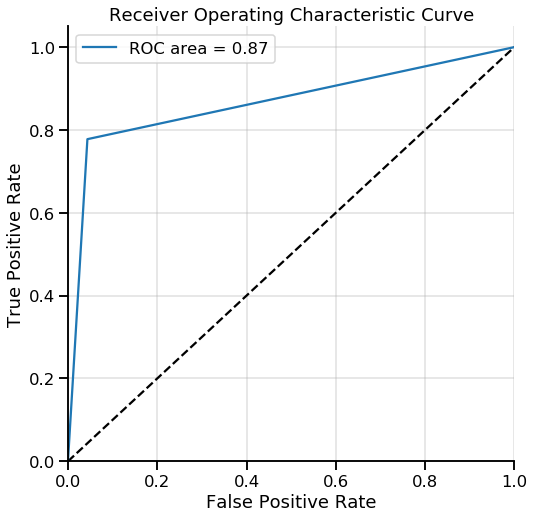

In [181]:
plot_roc_pr(dt_clf, X_test_tree_df, y_test, figsize=(8, 8))

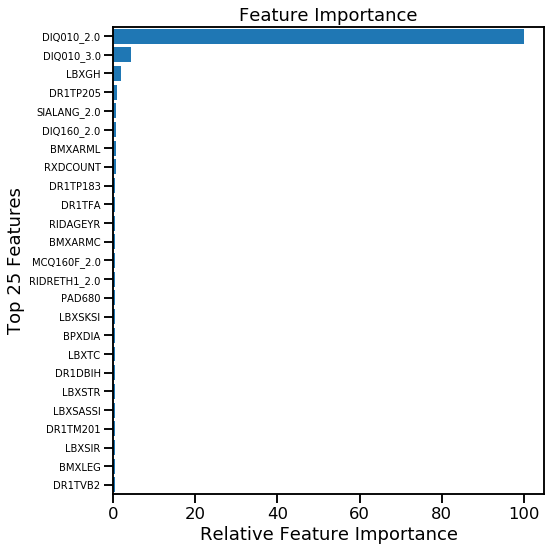

In [182]:
# What features are important to the decision tree model?
plot_top_features_imp(dt_clf, X_train_tree_df, 25)

#### Top featues:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
LBXGH = Glycohemoglobin (%)  
DR1TP205 = Dietary intake (one day) Polyunsaturated fatty acid 20:5  
SIALANG_2.0 = Language of interview = Spanish  
DIQ160_2.0 = Ever told you had prediabetes = NO  
BMXARML = Upper arm length (cm)  
RXDCOUNT = Number of prescription medications  
DR1TP183 = Dietary intake (one day) Polyunsaturated acid 18:3  (gm)  
DR1TFA = Dietary intake (one day) Folic acid (mcg)  

#### Decision Tree performs worse than logistic regression on this data. 

### c. Random Forest

In [183]:
# First use with default parameters. 
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0, class_weight='balanced')
rf_clf.fit(X_train_tree_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [184]:
y_pred = rf_clf.predict(X_test_tree_df)

In [185]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.894, 0.106])

In [186]:
# Get accuracy from test dataset. 
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.917 



In [187]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(rf_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 91.650% (0.703%)


In [188]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1982,   37],
       [ 161,  217]], dtype=int64)

In [189]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.92      0.98      0.95      2019
    Diabetes       0.85      0.57      0.69       378

    accuracy                           0.92      2397
   macro avg       0.89      0.78      0.82      2397
weighted avg       0.91      0.92      0.91      2397



In [190]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.98


In [191]:
from sklearn.metrics import roc_auc_score
y_scores=rf_clf.predict_proba(X_test_tree_df)
roc_auc_score(y_test, y_scores[:,1])

0.9751225788868185

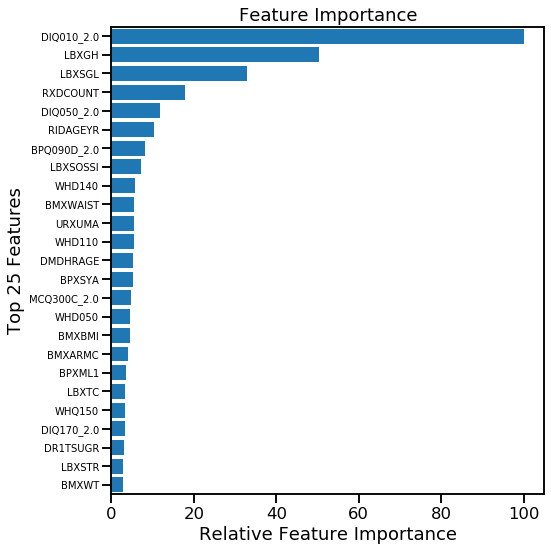

In [192]:
# What features are important to the default random forest model?
plot_top_features_imp(rf_clf, X_train_tree_df, 25)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
LBXGH = Glycohemoglobin (%)  
LBXSGL = Glucose, serum (mg/dL)  
RXDCOUNT = Number of prescription medications  
DIQ050_2.0 = Taking insulin now = NO  
RIDAGEYR = Age (yr)  
BPQ090D_2.0 = Told to take prescription for cholesterol = NO  
LBXSOSSI = Osmolality (mmol/Kg)  
WHD140 = Self-reported greatest weight(pounds)  
BMXWAIST = Waist circumference (cm)  

#### Now tune Random Forest. 

In [193]:
from sklearn.model_selection import RandomizedSearchCV

gridsearch_forest = RandomForestClassifier(random_state=0, class_weight='balanced')

params = {
    "max_features": ['sqrt', .2, .3, .4, .5],
    "n_estimators": [100, 200, 300, 400, 500, 600],
    "min_samples_leaf" : [1, 5, 10, 20, 50, 100]
}


rf_clf = RandomizedSearchCV(gridsearch_forest, param_distributions=params, cv=5, n_iter=15, n_jobs=-1, random_state=0)
rf_clf.fit(X_train_tree_df,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [194]:
rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [195]:
best_params = rf_clf.best_params_
best_params

{'n_estimators': 200, 'min_samples_leaf': 5, 'max_features': 0.5}

In [196]:
# Fit single classifier on tuned parameters so we can get feature importance. 
rf_clf = RandomForestClassifier(random_state=0, class_weight='balanced', **best_params)
rf_clf.fit(X_train_tree_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [197]:
y_pred = rf_clf.predict(X_test_tree_df)

In [198]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.813, 0.187])

In [199]:
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.948 



In [200]:
# Check accuracy with 5-fold cross validation. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(rf_clf, X_train_processed, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 95.405% (0.448%)


In [201]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1922,   97],
       [  27,  351]], dtype=int64)

In [202]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.99      0.95      0.97      2019
    Diabetes       0.78      0.93      0.85       378

    accuracy                           0.95      2397
   macro avg       0.88      0.94      0.91      2397
weighted avg       0.95      0.95      0.95      2397



In [203]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.95


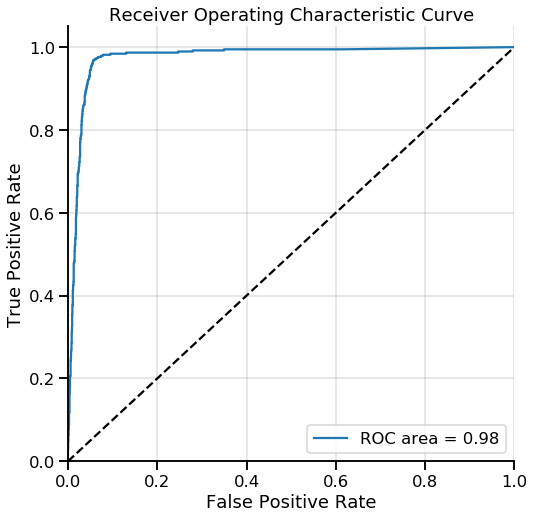

In [204]:
plot_roc_pr(rf_clf, X_test_tree_df, y_test, figsize=(8, 8))

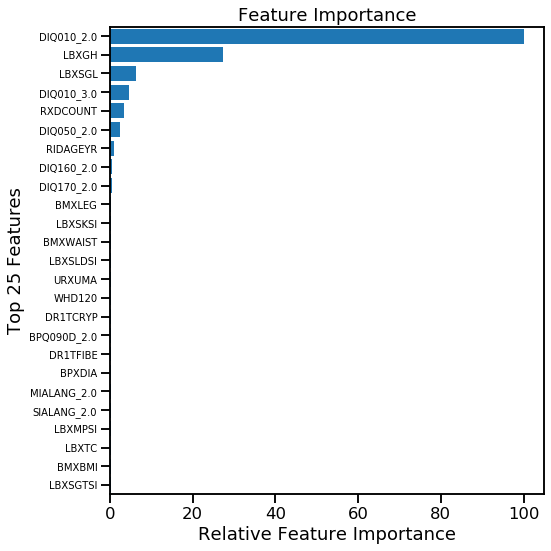

In [205]:
# What features are important to the tuned random forest model?
plot_top_features_imp(rf_clf, X_train_tree_df, 25)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
LBXGH = Glycohemoglobin (%)  
LBXSGL = Glucose, serum (mg/dL)  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
RXDCOUNT = Number of prescription medications  
DIQ050_2.0 = Taking insulin now = NO  
RIDAGEYR = Age (yr)  
DIQ160_2.0 = Ever told you have prediabetes = NO  
DIQ170_2.0 = Ever told you have a health risk for diabetes = NO  
BMXLEG = Upper Leg Length (cm)  

#### Tuned Random Forest is the best model so far, although we lost Precision in the tuning but gained better Recall.  

### d. Adaboost

In [206]:
from sklearn.ensemble import AdaBoostClassifier
a_clf = AdaBoostClassifier(random_state=0)
a_clf.fit(X_train_tree_df, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=0)

In [207]:
y_pred = a_clf.predict(X_test_tree_df)

In [208]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.845, 0.155])

In [209]:
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.942 



In [210]:
# Check accuracy with 5-fold cross validation. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(a_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 94.135% (0.575%)


In [211]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1953,   66],
       [  73,  305]], dtype=int64)

In [212]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.96      0.97      0.97      2019
    Diabetes       0.82      0.81      0.81       378

    accuracy                           0.94      2397
   macro avg       0.89      0.89      0.89      2397
weighted avg       0.94      0.94      0.94      2397



In [213]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.97


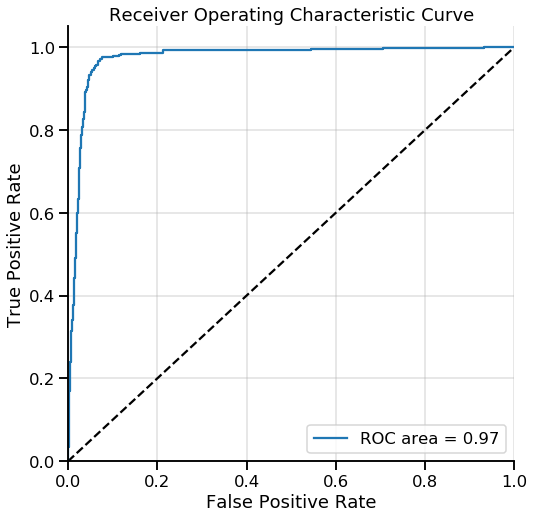

In [214]:
plot_roc_df(a_clf, X_test_tree_df, y_test, figsize=(8, 8))

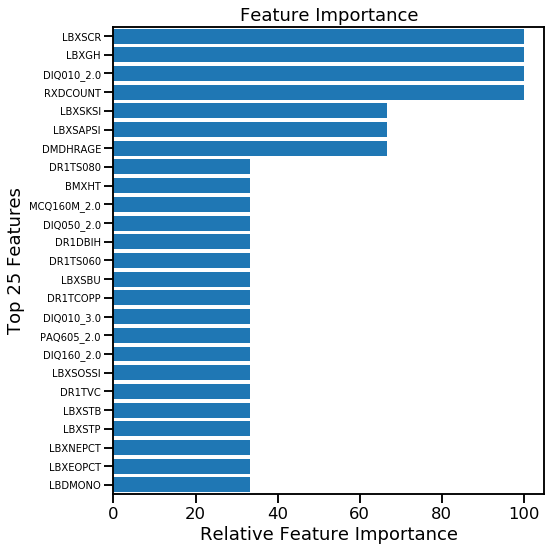

In [215]:
# What features are important to the Adaboost model?
plot_top_features_imp(a_clf, X_train_tree_df, 25)

#### Top features:  
LBXSCR = Creatinine (mg/dL)  
LBXGH = Glycohemoglobin (%)  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
RXDCOUNT = Number of prescription medications  
LBXSKSI = Potassium (mmol/L)  
LBXSAPSI = Alkaline phosphotase (U/L)  
DMDHRAGE = Age (yr) of person who owns or rents home  
DR1TS080 = Dietary intake (one day) Saturated fatty acid 8:0 (gm)  
BMXHT = Standing Height (cm)  
MCQ160M_2.0 = Ever told you had a thyroid problem = NO  

#### Adaboost does as well as any of the models so far out of the box. 

### e. Gradient Boosting

In [216]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=2)
gb_clf.fit(X_train_tree_df, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [217]:
y_pred = gb_clf.predict(X_test_tree_df)

In [218]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.821, 0.179])

In [219]:
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.953 



In [220]:
# Check accuracy with 5-fold cross validation. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(gb_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 95.405% (0.324%)


In [221]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1937,   82],
       [  30,  348]], dtype=int64)

In [222]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.98      0.96      0.97      2019
    Diabetes       0.81      0.92      0.86       378

    accuracy                           0.95      2397
   macro avg       0.90      0.94      0.92      2397
weighted avg       0.96      0.95      0.95      2397



In [223]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.96


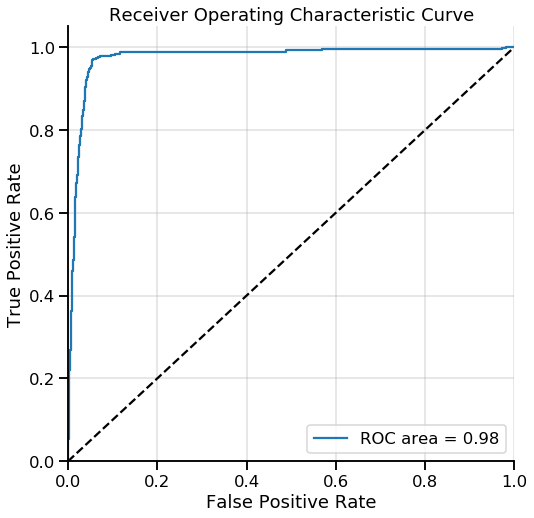

In [224]:
plot_roc_df(gb_clf, X_test_tree_df, y_test, figsize=(8, 8))

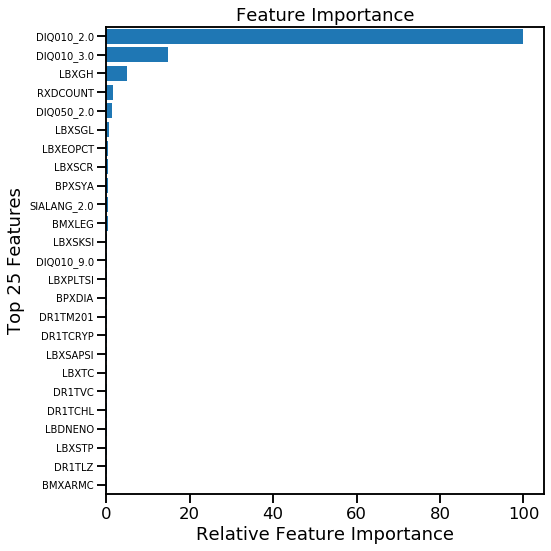

In [225]:
# What features are important to the Gradient Boosting model?
plot_top_features_imp(gb_clf, X_train_tree_df, 25)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
LBXGH = Glycohemoglobin (%)  
RXDCOUNT = Number of prescription medications   
DIQ050_2.0 = Taking insulin now = NO  
LBXSGL = Glucose, serum (mg/dL)  
LBXEOPCT = Eosinophils percent (%)  
LBXSCR = Creatinine (mg/dL)  
BYXSYA = Systolic blood pressure (mm Hg)  
SIALANG_2.0 = Language of interview = Spanish    

#### Gradient Boosting is the best so far of the untuned models. 

### f. XGBoost

In [226]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [227]:
# Start with defaults. 
xgb_clf = XGBClassifier(objective='multi:softmax', num_class=2, random_state=0) 
xgb_clf.fit(X_train_tree_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=2, objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [228]:
y_pred = xgb_clf.predict(X_test_tree_df)

In [229]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.827, 0.173])

In [230]:
# Test set accuracy
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.952 



In [231]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(xgb_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 95.494% (0.537%)


In [232]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1943,   76],
       [  40,  338]], dtype=int64)

In [233]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.98      0.96      0.97      2019
    Diabetes       0.82      0.89      0.85       378

    accuracy                           0.95      2397
   macro avg       0.90      0.93      0.91      2397
weighted avg       0.95      0.95      0.95      2397



In [234]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.96


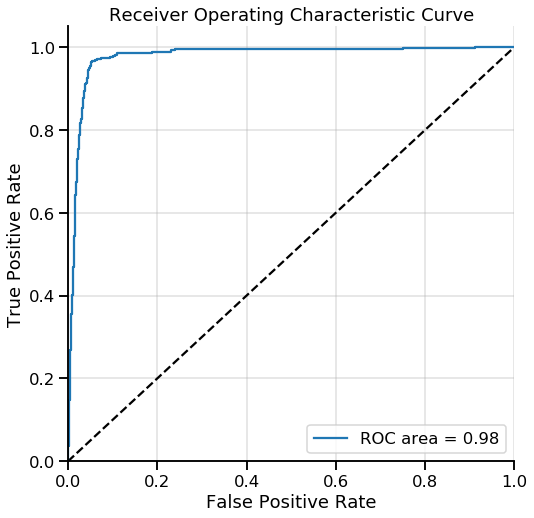

In [235]:
# Refit XGBoost Classifier with objective=multi:softprob to get probabilities instead of classes for ROC curve. 
prob_clf = XGBClassifier(objective='multi:softprob', num_class=2, random_state=0)
prob_clf.fit(X_train_tree_df, y_train)
plot_roc_pr(prob_clf, X_test_tree_df, y_test, figsize=(8, 8))

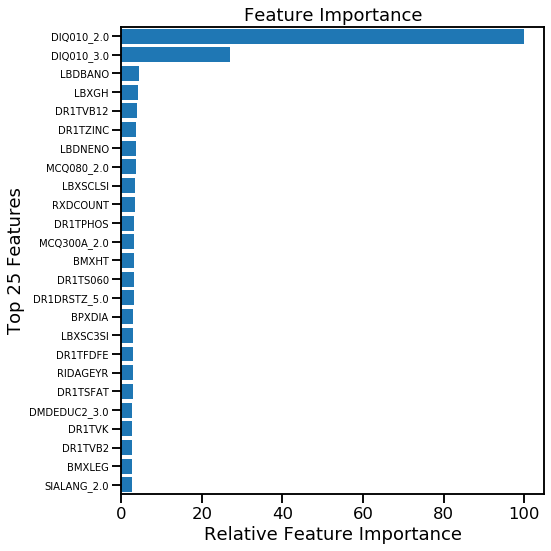

In [236]:
# What features are important to the XGBoost model?
plot_top_features_imp(xgb_clf, X_train_tree_df, 25)

#### Top features:  
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
LBDBANO = Basophils number (1000 cells/uL)  
LBXGH = Glycohemoglobin (%)  
DR1TVB12 = Dietary intake (one day) Vitamin B12 (mcg)  
DR1TZINC = Dietary intake (one day) Zinc (mg)  
LBDNENO = Segmented neutrophils num (1000 cell/uL)  
MCQ080_2.0 = Doctor ever said you were overweight = NO  
LBXSCLSI = Chloride (mmol/L)  
RXDCOUNT = Number of prescription medications  

#### Now tune XGBoost. 

In [237]:
# Tune XGBoost model with RandomizedSearchCV. 
from scipy import stats
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score

xgb_clf = XGBClassifier(objective = 'multi:softmax', num_class=2, random_state=0)
param_dist = {'n_estimators': stats.randint(150, 500),
              'learning_rate': stats.uniform(0.01, 0.07),
              'subsample': stats.uniform(0.3, 0.7),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'gamma': [0, .1, .2, .3, .4, .5],
              'colsample_bytree': stats.uniform(0.5, 0.45),
              'min_child_weight': [1, 2, 3]
             }
clf = RandomizedSearchCV(xgb_clf, param_distributions = param_dist, cv=5, n_iter=15, n_jobs=-1, random_state=0)
clf.fit(X_train_tree_df, y_train)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None, num_class=2,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_l...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000013982357948>,
                                        'max

In [238]:
clf.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6987699145619805,
              gamma=0.3, learning_rate=0.018413759284921824, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=None, n_estimators=248,
              n_jobs=1, nthread=None, num_class=2, objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9163331224768168,
              verbosity=1)

In [239]:
clf.best_params_

{'colsample_bytree': 0.6987699145619805,
 'gamma': 0.3,
 'learning_rate': 0.018413759284921824,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 248,
 'subsample': 0.9163331224768168}

In [240]:
# Fit single classifier with optimal parameters so we can get feature importance. 
params = clf.best_params_
xgb_clf =  XGBClassifier(objective='multi:softmax', num_class=2, random_state=0)
xgb_clf.set_params(**params)
xgb_clf.fit(X_train_tree_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6987699145619805,
              gamma=0.3, learning_rate=0.018413759284921824, max_delta_step=0,
              max_depth=6, min_child_weight=3, missing=None, n_estimators=248,
              n_jobs=1, nthread=None, num_class=2, objective='multi:softmax',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9163331224768168,
              verbosity=1)

In [241]:
y_pred = xgb_clf.predict(X_test_tree_df)

In [242]:
# How close is predicted distribution to original distribution?
predict_proportion(y_pred)

array([0.827, 0.173])

In [243]:
# Accuracy on test dataset
from sklearn.metrics import accuracy_score
print ("Overall model accuracy:{0:.3f}".format(accuracy_score(y_test,y_pred)),"\n")

Overall model accuracy:0.951 



In [244]:
# Check accuracy with 5-fold cross validation on training data. 
from sklearn.model_selection import StratifiedKFold, cross_val_score
kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(xgb_clf, X_train_tree_df, y_train, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 95.655% (0.596%)


In [245]:
from sklearn.metrics import confusion_matrix
conf_ma = confusion_matrix(y_test, y_pred)
conf_ma

array([[1942,   77],
       [  41,  337]], dtype=int64)

In [246]:
from sklearn.metrics import classification_report
target_names = ['No Diabetes', 'Diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 No Diabetes       0.98      0.96      0.97      2019
    Diabetes       0.81      0.89      0.85       378

    accuracy                           0.95      2397
   macro avg       0.90      0.93      0.91      2397
weighted avg       0.95      0.95      0.95      2397



In [247]:
# As this is a medical dataset, calculate Specificity. We already have Sensitivity as it is the same as Recall. 
specificity = np.round(conf_ma[0, 0] / (conf_ma[0, 0] + conf_ma[0, 1]), 2)
print(f"Diabetes Specificity: {specificity}")

Diabetes Specificity: 0.96


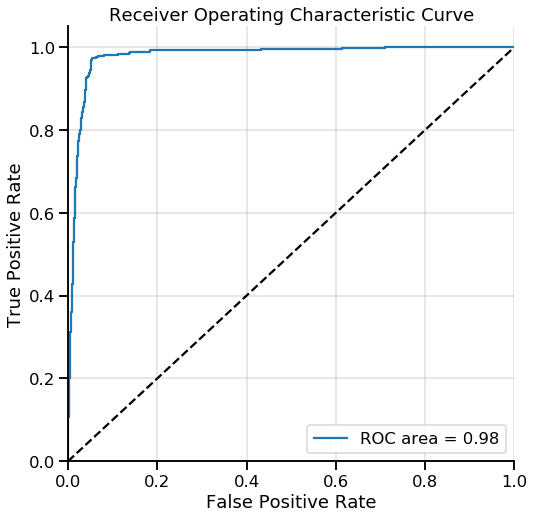

In [248]:
# Fit classifier again with objective='multi:softprob' to get probabilities for ROC curve. User same parameters other than
#    change in objective. 
prob_clf = XGBClassifier(objective='multi:softprob', num_class=2, random_state=0)
prob_clf.set_params(**params)
prob_clf.fit(X_train_tree_df, y_train)
plot_roc_pr(prob_clf, X_test_tree_df, y_test, figsize=(8, 8))

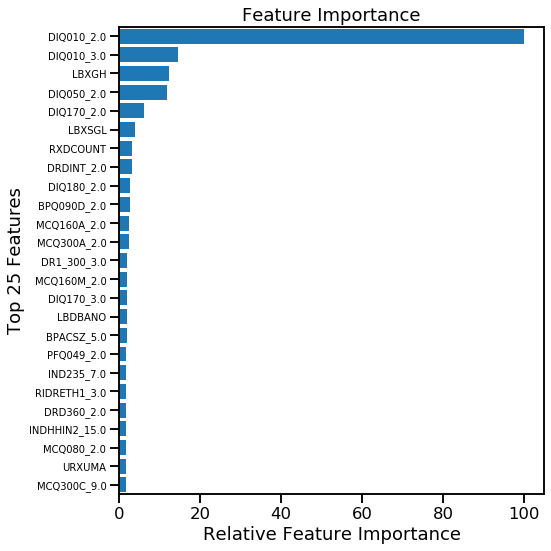

In [249]:
# What features are important to the XGBoost model?
plot_top_features_imp(xgb_clf, X_train_tree_df, 25)

#### Top featues:   
DIQ010_2.0 = Doctor ever said you have diabetes = NO  
DIQ010_3.0 = Doctor ever said you have diabetes = BORDERLINE  
LBXGH = Glycohemoglobin (%)  
DIQ050_2.0 = Taking insulin now = NO  
DIQ170_2.0 = Ever told you had a health risk for diabetes = NO  
LBXSGL = Glucose, serum (mg/dL)  
RXDCOUNT = Number of prescription medications  
DRDINT_2.0 = Number of days tracked dietary intake in survey = 2    
DIQ180_2.0 = Blood test for high blood sugar in past three years = NO   
BPQ090D_2.0 = Ever told to take a prescription for cholesterol = NO  

#### Tuning did not change the XGBoost model this time. The tuned model's scores are nearly identical to those of the untuned model. Tuned XGBoost and untuned Gradient Boosting have similar scores. It would be interesting to see how a tuned Gradient Boosting model compared to the tuned XGBoost model. 

#### Summary of results pre-tuning:

| Model | Accuracy (test) | Accuracy (5-fold cv train) | Precision | Recall/Sensitivity | Specificity | F1-Score | ROC AUC |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | .935 | 93.8 (.723) | .75 | .88 | .95 | .81 | .97 |
| Decision Tree | .928 | 92.0 (.576) | .77 | .78 | .96 | .77 | .87 |
| Random Forest | .917 | 91.7 (.703) | .85 |.57 | .98 | .69 | .97 |
| Adaboost | .942 | 94.1 (.575) | .82 | .81 | .97 | .81 | .97 |
| Gradient Boosting | .953 | 95.4 (.324) | .81 | .92 |.96 | .86 | .98 |
| XGBoost | .952 | 95.5 (.537) | .82 | .89 | .96 | .85 | .98 |

#### Post-tuning:

| Model | Accuracy (test) | Accuracy (5-fold cv train) | Precision | Recall/Sensitivity | Specificity | F1-Score | ROC AUC |
| ---| --- | --- | --- | ---| --- | --- | --- |
| Random Forest | .948 | 95.4 (.448) | .78 | .93 | .95 | .85 | .98 |
| XGBoost | .951 | 95.7 (.596) | .81 | .89 | .96 | .85 | .98 |

#### Note: Accuracy is for overall model. All other measures are for positive class: Diabetes. 
#### As this is medical data, reported Sensitivity & Specificity in addition to Precision & Recall.